In [1]:
# import libraries 
import pandas as pd
import numpy as np
import math
from scipy.stats import kurtosis, skew

import matplotlib.pyplot as plt
from matplotlib import colorbar
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from pickle import dump, load

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

np.random_state = 42

## Temizlenmiş Datasetimizi yüklüyoruz (sd_listinings) 

In [2]:
sd_listings = pd.read_csv('data/sd_listings', index_col= 0)
sd_listings.head(3)

id                            listing_url  latitude  longitude  \
0  33159143  https://www.airbnb.com/rooms/33159143  32.91736 -117.07635   
1  17138468  https://www.airbnb.com/rooms/17138468  32.84067 -117.27443   
2  21898446  https://www.airbnb.com/rooms/21898446  32.79797 -117.24250   

   zipcode                                              name  \
0    92131  PRIVATE ROOM, SAFE NEIGHBORHOOD IN SCRIPPS RANCH   
1    92037                                     NOT AVAILABLE   
2    92109                         Townhome in Pacific Beach   

                                             summary  \
0  80% of the house + yourCozy room ... in Scripp...   
1  AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...   
2  Hi! We are basically renting this master for a...   

                       space  \
0  Full bed, private bath...   
1                        NaN   
2                        NaN   

                                         description  \
0  80% of the house + yourCozy room ... in Scripp...   
1  AVAILABLE ONLY IN WINTER PRIME La Jolla Villag...   
2  Hi! We are basically renting this master for a...   

                               neighborhood_overview  \
0  The neighborhood is a typical Southern Califor...   
1                                                NaN   
2                                                NaN   

                                               notes  \
0  Have alarm system if you choose to use... I wi...   
1                                                NaN   
2                                                NaN   

                                             transit  \
0  You can park in the drive way or plenty of spa...   
1                                                NaN   
2                                                NaN   

                                              access  \
0  Kitchen, Dining room, Living room, Very Comfor...   
1                                                NaN   
2                                                NaN   

                                         interaction house_rules  \
0  I lived in San Diego 40+ years, love to share ...      #NAME?   
1                                                NaN         NaN   
2                                                NaN         NaN   

  property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0         House     Private room             1        1.0       1.0   1.0   
1     Apartment  Entire home/apt             1        2.0       2.0   3.0   
2     Townhouse     Private room             1        1.0       1.0   1.0   

   bed_type                                          amenities  nightly_price  \
0  Real Bed  {Wifi,Kitchen,"Free parking on premises",Heati...         1100.0   
1  Real Bed  {TV,Wifi,"Air conditioning",Kitchen,"Free park...         1400.0   
2  Real Bed  {TV,Wifi,Kitchen,"Free parking on premises","P...         1250.0   

   price_per_stay  security_deposit  cleaning_fee  guests_included  \
0          1100.0            1000.0           0.0                1   
1          1400.0               NaN           NaN                1   
2          1250.0               NaN           NaN                1   

   extra_people  minimum_nights  maximum_nights    host_id  \
0           0.0              60              90  249661563   
1           0.0              30            1125   79755951   
2           0.0              30              30  159773487   

                                      host_url host_since  \
0  https://www.airbnb.com/users/show/249661563    3/18/19   
1   https://www.airbnb.com/users/show/79755951    6/24/16   
2  https://www.airbnb.com/users/show/159773487   11/22/17   

                                          host_about  host_response_time  \
0  Retired businessman of 30 years in this commun...  within a few hours   
1                             Quiet and considerate.                 NaN   
2                                                NaN          

## Select columns for modeling

In [3]:
sd_listings.columns

Index(['id', 'listing_url', 'latitude', 'longitude', 'zipcode', 'name',
       'summary', 'space', 'description', 'neighborhood_overview', 'notes',
       'transit', 'access', 'interaction', 'house_rules', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'nightly_price', 'price_per_stay',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'host_id', 'host_url', 'host_since',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'neighbourhood_cleansed',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'number_of_reviews', 'number_of_stays',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license',

In [4]:
modeling_cols = ['id', 'listing_url', 'latitude', 'longitude', 'neighbourhood_cleansed',
               'zipcode', 'property_type', 'room_type', 'accommodates', 
               'bathrooms', 'bedrooms', 'beds',
               'bed_type','nightly_price', 'price_per_stay',
               'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
               'minimum_nights', 'maximum_nights','host_response_time', 'host_response_rate',
               'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic',
               'host_identity_verified', 'number_of_reviews', 'number_of_stays',
               'review_scores_rating', 'review_scores_accuracy',
               'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location',
               'review_scores_value', 'requires_license', 'instant_bookable',
               'is_business_travel_ready', 'cancellation_policy',
               'require_guest_profile_picture', 'require_guest_phone_verification']

In [5]:
sd_modeling = sd_listings[modeling_cols]
sd_modeling.tail(2)

id                            listing_url  latitude  longitude  \
13049  17975942  https://www.airbnb.com/rooms/17975942  32.83598 -117.27878   
13050  33160513  https://www.airbnb.com/rooms/33160513  32.74357 -117.17679   

      neighbourhood_cleansed  zipcode property_type        room_type  \
13049               La Jolla    92037         House  Entire home/apt   
13050                Midtown    92103   Condominium  Entire home/apt   

       accommodates  bathrooms  bedrooms  beds  bed_type  nightly_price  \
13049            21        5.5       7.0  13.0  Real Bed         1305.0   
13050            24        8.0       8.0  10.0  Real Bed          398.0   

       price_per_stay  security_deposit  cleaning_fee  guests_included  \
13049          1305.0            1000.0         800.0               21   
13050           398.0             500.0         499.0               24   

       extra_people  minimum_nights  maximum_nights host_response_time  \
13049           0.0               1            1125     within an hour   
13050           0.0               1             365     within an hour   

       host_response_rate  host_is_superhost  host_total_listings_count  \
13049                99.0                  0                      403.0   
13050               100.0                  1                      123.0   

       host_has_profile_pic  host_identity_verified  number_of_reviews  \
13049                     1                       0                  4   
13050                     1                       0                  1   

       number_of_stays  review_scores_rating  review_scores_accuracy  \
13049                8                  80.0                     9.0   
13050                2                  80.0                    10.0   

       review_scores_cleanliness  review_scores_checkin  \
13049                        8.0                   10.0   
13050                       10.0                    6.0   

       review_scores_communication  review_scores_location  \
13049                          8.0                    10.0   
13050                         10.0                    10.0   

       review_scores_value  requires_license  instant_bookable  \
13049                  9.0                 0                 1   
13050                  8.0                 0                 1   

       is_business_travel_ready cancellation_policy  \
13049                         0     super_strict_60   
13050                         0     super_strict_60   

       require_guest_profile_picture  require_guest_phone_verification  
13049                              0                                 0  
13050                              0                                 0

## Kalan eksik değerleri ele al

In [6]:
# check missing
sd_modeling.isna().sum()

id                                     0
listing_url                            0
latitude                               0
longitude                              0
neighbourhood_cleansed                 0
zipcode                                0
property_type                          0
room_type                              0
accommodates                           0
bathrooms                              3
bedrooms                               3
beds                                   9
bed_type                               0
nightly_price                          0
price_per_stay                         0
security_deposit                    2674
cleaning_fee                        1504
guests_included                        0
extra_people                           0
minimum_nights                         0
maximum_nights                         0
host_response_time                  2144
host_response_rate                     0
host_is_superhost                      0
host_total_listi

### Imputing missing `beds`

In [7]:
# Eksik beds değerlerini bedrooms sütunundaki değerlerle doldur.
sd_modeling['beds'] = sd_modeling['beds'].fillna(sd_modeling['bedrooms'])

### Eksik security_deposit ve cleaning_fee değerlerini 0 ile doldurma.

In [8]:
sd_modeling[['security_deposit', 'cleaning_fee']] = sd_modeling[['security_deposit', 'cleaning_fee']].fillna(0)

### Impute missing values in `host_response_time`

In [9]:
# Eksik değerler için 'no response' adlı yeni bir değer atayın.
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].fillna('no response')

In [10]:
sd_modeling['host_response_time'].value_counts()

host_response_time
within an hour        8411
no response           2144
within a few hours    1587
within a day           762
a few days or more     147
Name: count, dtype: int64

### Eksik değerleri olan kalan satırları silin yani özelliklerin doğası gereği doldurulamayan değerler.

In [11]:
# Drop rows that has NaN values on selected columns
sd_modeling = sd_modeling.dropna()

In [12]:
sd_modeling.isna().sum()

id                                  0
listing_url                         0
latitude                            0
longitude                           0
neighbourhood_cleansed              0
zipcode                             0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                           0
bedrooms                            0
beds                                0
bed_type                            0
nightly_price                       0
price_per_stay                      0
security_deposit                    0
cleaning_fee                        0
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
host_response_time                  0
host_response_rate                  0
host_is_superhost                   0
host_total_listings_count           0
host_has_profile_pic                0
host_identit

### Temizleme işleminden sonra veri türlerini kontrol ediyoruz

In [13]:
# convert to appropriate datatype
sd_modeling['bedrooms'] = sd_modeling['bedrooms'].astype(float)
sd_modeling['zipcode'] = sd_modeling['zipcode'].astype(int)
sd_modeling['latitude'] = sd_modeling['latitude'].astype(float)
sd_modeling['longitude'] = sd_modeling['longitude'].astype(float)
sd_modeling['beds'] = sd_modeling['beds'].astype(float).astype(int)
sd_modeling['id'] = sd_modeling['id'].astype(int)

In [14]:
sd_modeling.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13040 entries, 0 to 13050
Data columns (total 42 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                13040 non-null  int64  
 1   listing_url                       13040 non-null  object 
 2   latitude                          13040 non-null  float64
 3   longitude                         13040 non-null  float64
 4   neighbourhood_cleansed            13040 non-null  object 
 5   zipcode                           13040 non-null  int64  
 6   property_type                     13040 non-null  object 
 7   room_type                         13040 non-null  object 
 8   accommodates                      13040 non-null  int64  
 9   bathrooms                         13040 non-null  float64
 10  bedrooms                          13040 non-null  float64
 11  beds                              13040 non-null  int64  
 12  bed_type 

In [15]:
sd_modeling.describe()

id      latitude     longitude        zipcode  accommodates  \
count  1.304000e+04  13040.000000  13040.000000   13040.000000  13040.000000   
mean   2.137447e+07     32.768302   -117.180227   92119.114724      4.467178   
std    1.050810e+07      0.065387      0.064364    7463.790967      3.009354   
min    6.000000e+00     32.531040   -117.281990   22000.000000      1.000000   
25%    1.358951e+07     32.725277   -117.244425   92101.000000      2.000000   
50%    2.180290e+07     32.757190   -117.167085   92107.000000      4.000000   
75%    3.069297e+07     32.798053   -117.140267   92110.000000      6.000000   
max    3.786276e+07     33.086070   -116.926530  921096.000000     24.000000   

          bathrooms      bedrooms          beds  nightly_price  \
count  13040.000000  13040.000000  13040.000000   13040.000000   
mean       1.507937      1.637960      2.384126     223.751457   
std        0.905070      1.194929      1.900810     344.150092   
min        0.000000      0.000000      0.000000       0.000000   
25%        1.000000      1.000000      1.000000      85.000000   
50%        1.000000      1.000000      2.000000     140.000000   
75%        2.000000      2.000000      3.000000     250.000000   
max       27.500000     14.000000     25.000000   10000.000000   

       price_per_stay  security_deposit  cleaning_fee  guests_included  \
count    13040.000000      13040.000000  13040.000000     13040.000000   
mean       531.875153        269.593482     95.210736         2.307899   
std        938.710079        485.396186    104.694193         2.323067   
min          0.000000          0.000000      0.000000         1.000000   
25%        130.000000          0.000000     25.000000         1.000000   
50%        297.500000        100.000000     65.000000         1.000000   
75%        500.000000        400.000000    130.000000         2.000000   
max      15000.000000       5000.000000   1025.000000        24.000000   

       extra_people  minimum_nights  maximum_nights  host_response_rate  \
count  13040.000000    13040.000000    13040.000000        13040.000000   
mean      13.542255        4.749923      619.959202           80.842408   
std       27.612207       15.714078     1297.673611           37.331230   
min        0.000000        1.000000        1.000000            0.000000   
25%        0.000000        1.000000       29.000000           91.000000   
50%        0.000000        2.000000      999.000000          100.000000   
75%       20.000000        3.000000     1125.000000          100.000000   
max      300.000000      800.000000    99999.000000          100.000000   

       host_is_superhost  host_total_listings_count  host_has_profile_pic  \
count       13040.000000               13040.000000          13040.000000   
mean            0.368635                  42.848543              0.998543   
std             0.482453                 175.390234              0.038145   
min             0.000000                   0.000000              0.000000   
25%             0.000000                   1.000000              1.000000   
50%             0.000000                   2.000000              1.000000   
75%             1.000000                   9.000000              1.000000   
max             1.000000                1737.000000              1.000000   

       host_identity_verified  number_of_reviews  number_of_stays  \
count            13040.000000       13040.000000     13040.000000   
mean                 0.486273          34.884509        69.769018   
std                  0.499831          60.034597       120.069193   
min                  0.000000           0.000000         0.000000   
25%                  0.000000           2.000000         4.000000   
50%                  0.000000          10.000000        20.000000   
75%                  1.000000          41.000000        82.000000   
max                  1.000000         786.000000      1572.000000   

       review_scores_rating  review_scores

In [16]:
sd_modeling[sd_modeling['zipcode']==92307]

id                            listing_url  latitude  longitude  \
12935  34895037  https://www.airbnb.com/rooms/34895037  32.88529 -117.24642   

      neighbourhood_cleansed  zipcode property_type        room_type  \
12935           Torrey Pines    92307         House  Entire home/apt   

       accommodates  bathrooms  bedrooms  beds  bed_type  nightly_price  \
12935            16        8.0       8.0     8  Real Bed         1518.0   

       price_per_stay  security_deposit  cleaning_fee  guests_included  \
12935          1518.0            1000.0         924.0               16   

       extra_people  minimum_nights  maximum_nights host_response_time  \
12935           0.0               1            1125     within an hour   

       host_response_rate  host_is_superhost  host_total_listings_count  \
12935                99.0                  0                      403.0   

       host_has_profile_pic  host_identity_verified  number_of_reviews  \
12935                     1                       0                  0   

       number_of_stays  review_scores_rating  review_scores_accuracy  \
12935                0                  97.0                    10.0   

       review_scores_cleanliness  review_scores_checkin  \
12935                       10.0                   10.0   

       review_scores_communication  review_scores_location  \
12935                         10.0                    10.0   

       review_scores_value  requires_license  instant_bookable  \
12935                 10.0                 0                 1   

       is_business_travel_ready cancellation_policy  \
12935                         0     super_strict_60   

       require_guest_profile_picture  require_guest_phone_verification  
12935                              0                                 0

In [17]:
# save as csv
path = "data/"

sd_modeling.to_csv(path + 'sd_modeling_with_urls')

In [18]:
sd_modeling = sd_modeling.drop(columns = 'listing_url')
sd_modeling.head()

id  latitude  longitude neighbourhood_cleansed  zipcode  \
0  33159143  32.91736 -117.07635          Scripps Ranch    92131   
1  17138468  32.84067 -117.27443               La Jolla    92037   
2  21898446  32.79797 -117.24250          Pacific Beach    92109   
3  25948680  32.77545 -117.05923           College Area    92120   
4   1756516  32.84619 -117.27558               La Jolla    92037   

  property_type        room_type  accommodates  bathrooms  bedrooms  beds  \
0         House     Private room             1        1.0       1.0     1   
1     Apartment  Entire home/apt             1        2.0       2.0     3   
2     Townhouse     Private room             1        1.0       1.0     1   
3     Apartment  Entire home/apt             1        1.0       1.0     1   
4   Condominium     Private room             1        1.0       1.0     1   

   bed_type  nightly_price  price_per_stay  security_deposit  cleaning_fee  \
0  Real Bed         1100.0          1100.0            1000.0           0.0   
1  Real Bed         1400.0          1400.0               0.0           0.0   
2  Real Bed         1250.0          1250.0               0.0           0.0   
3  Real Bed         1150.0          1150.0               0.0           0.0   
4  Real Bed          110.0           110.0             200.0           0.0   

   guests_included  extra_people  minimum_nights  maximum_nights  \
0                1           0.0              60              90   
1                1           0.0              30            1125   
2                1           0.0              30              30   
3                1           0.0              31              40   
4                1          50.0             180             365   

   host_response_time  host_response_rate  host_is_superhost  \
0  within a few hours               100.0                  0   
1         no response                 0.0                  0   
2         no response                 0.0                  0   
3         no response                 0.0                  0   
4        within a day                67.0                  0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                     1                       0   
1                        1.0                     1                       0   
2                        1.0                     1                       0   
3                        1.0                     1                       0   
4                        6.0                     1                       1   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                  0                0                  98.0   
1                  2                4                 100.0   
2                  0                0                  97.0   
3                  0                0                  98.0   
4                  2                4                  90.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                     7.0                        7.0                    8.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                         10.0                    10.0                 10.0   
4                          8.0                     9.0                 10.0   

   requires_license  instant_bookable  is_business_travel_ready  \
0        

In [19]:
# save as csv
path = "data/"

sd_modeling.to_csv(path + 'sd_modeling_cleaned')

## Kategorik Özelliklerin Keşfi

### Checking value counts for each categorical feature

In [20]:
cat_cols = sd_modeling.select_dtypes(include = ['object']).columns
cat_cols

Index(['neighbourhood_cleansed', 'property_type', 'room_type', 'bed_type',
       'host_response_time', 'cancellation_policy'],
      dtype='object')

In [21]:
for col in cat_cols:
    values = sd_modeling[col].value_counts()
    print(values, "\n")

neighbourhood_cleansed
Mission Bay        1589
Pacific Beach      1040
La Jolla            845
East Village        821
North Hills         737
                   ... 
Lincoln Park          3
Horton Plaza          3
Eastlake Woods        2
Eastlake Trails       1
Thomy Locust Pl       1
Name: count, Length: 103, dtype: int64 

property_type
House                     4569
Apartment                 3391
Condominium               1990
Townhouse                  713
Guesthouse                 481
Guest suite                471
Bungalow                   298
Cottage                    289
Loft                       259
Villa                       88
Serviced apartment          83
Hostel                      72
Camper/RV                   57
Bed and breakfast           48
Other                       39
Boat                        35
Resort                      35
Tiny house                  29
Boutique hotel              26
Hotel                       15
Aparthotel                  12
Tent   

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25,20), sharey=True)

# Create bar plots
cat_cols = list(cat_cols)

for col, ax in zip(cat_cols, axes.flatten()):
    (sd_modeling.groupby(col)        # group values together by column of interest
         .count()['nightly_price']    # Her grup için nightly_price'in ortalamasını alıyoruz
         .sort_values()              # sort the groups artan sıraya göre
         .plot
         .bar(ax=ax))                # bar grafik oluşturma 
    
    ax.set_title(col)                # Make the title the name of the column
    
fig.tight_layout()

### Sayısal özelliklerin dağılımı

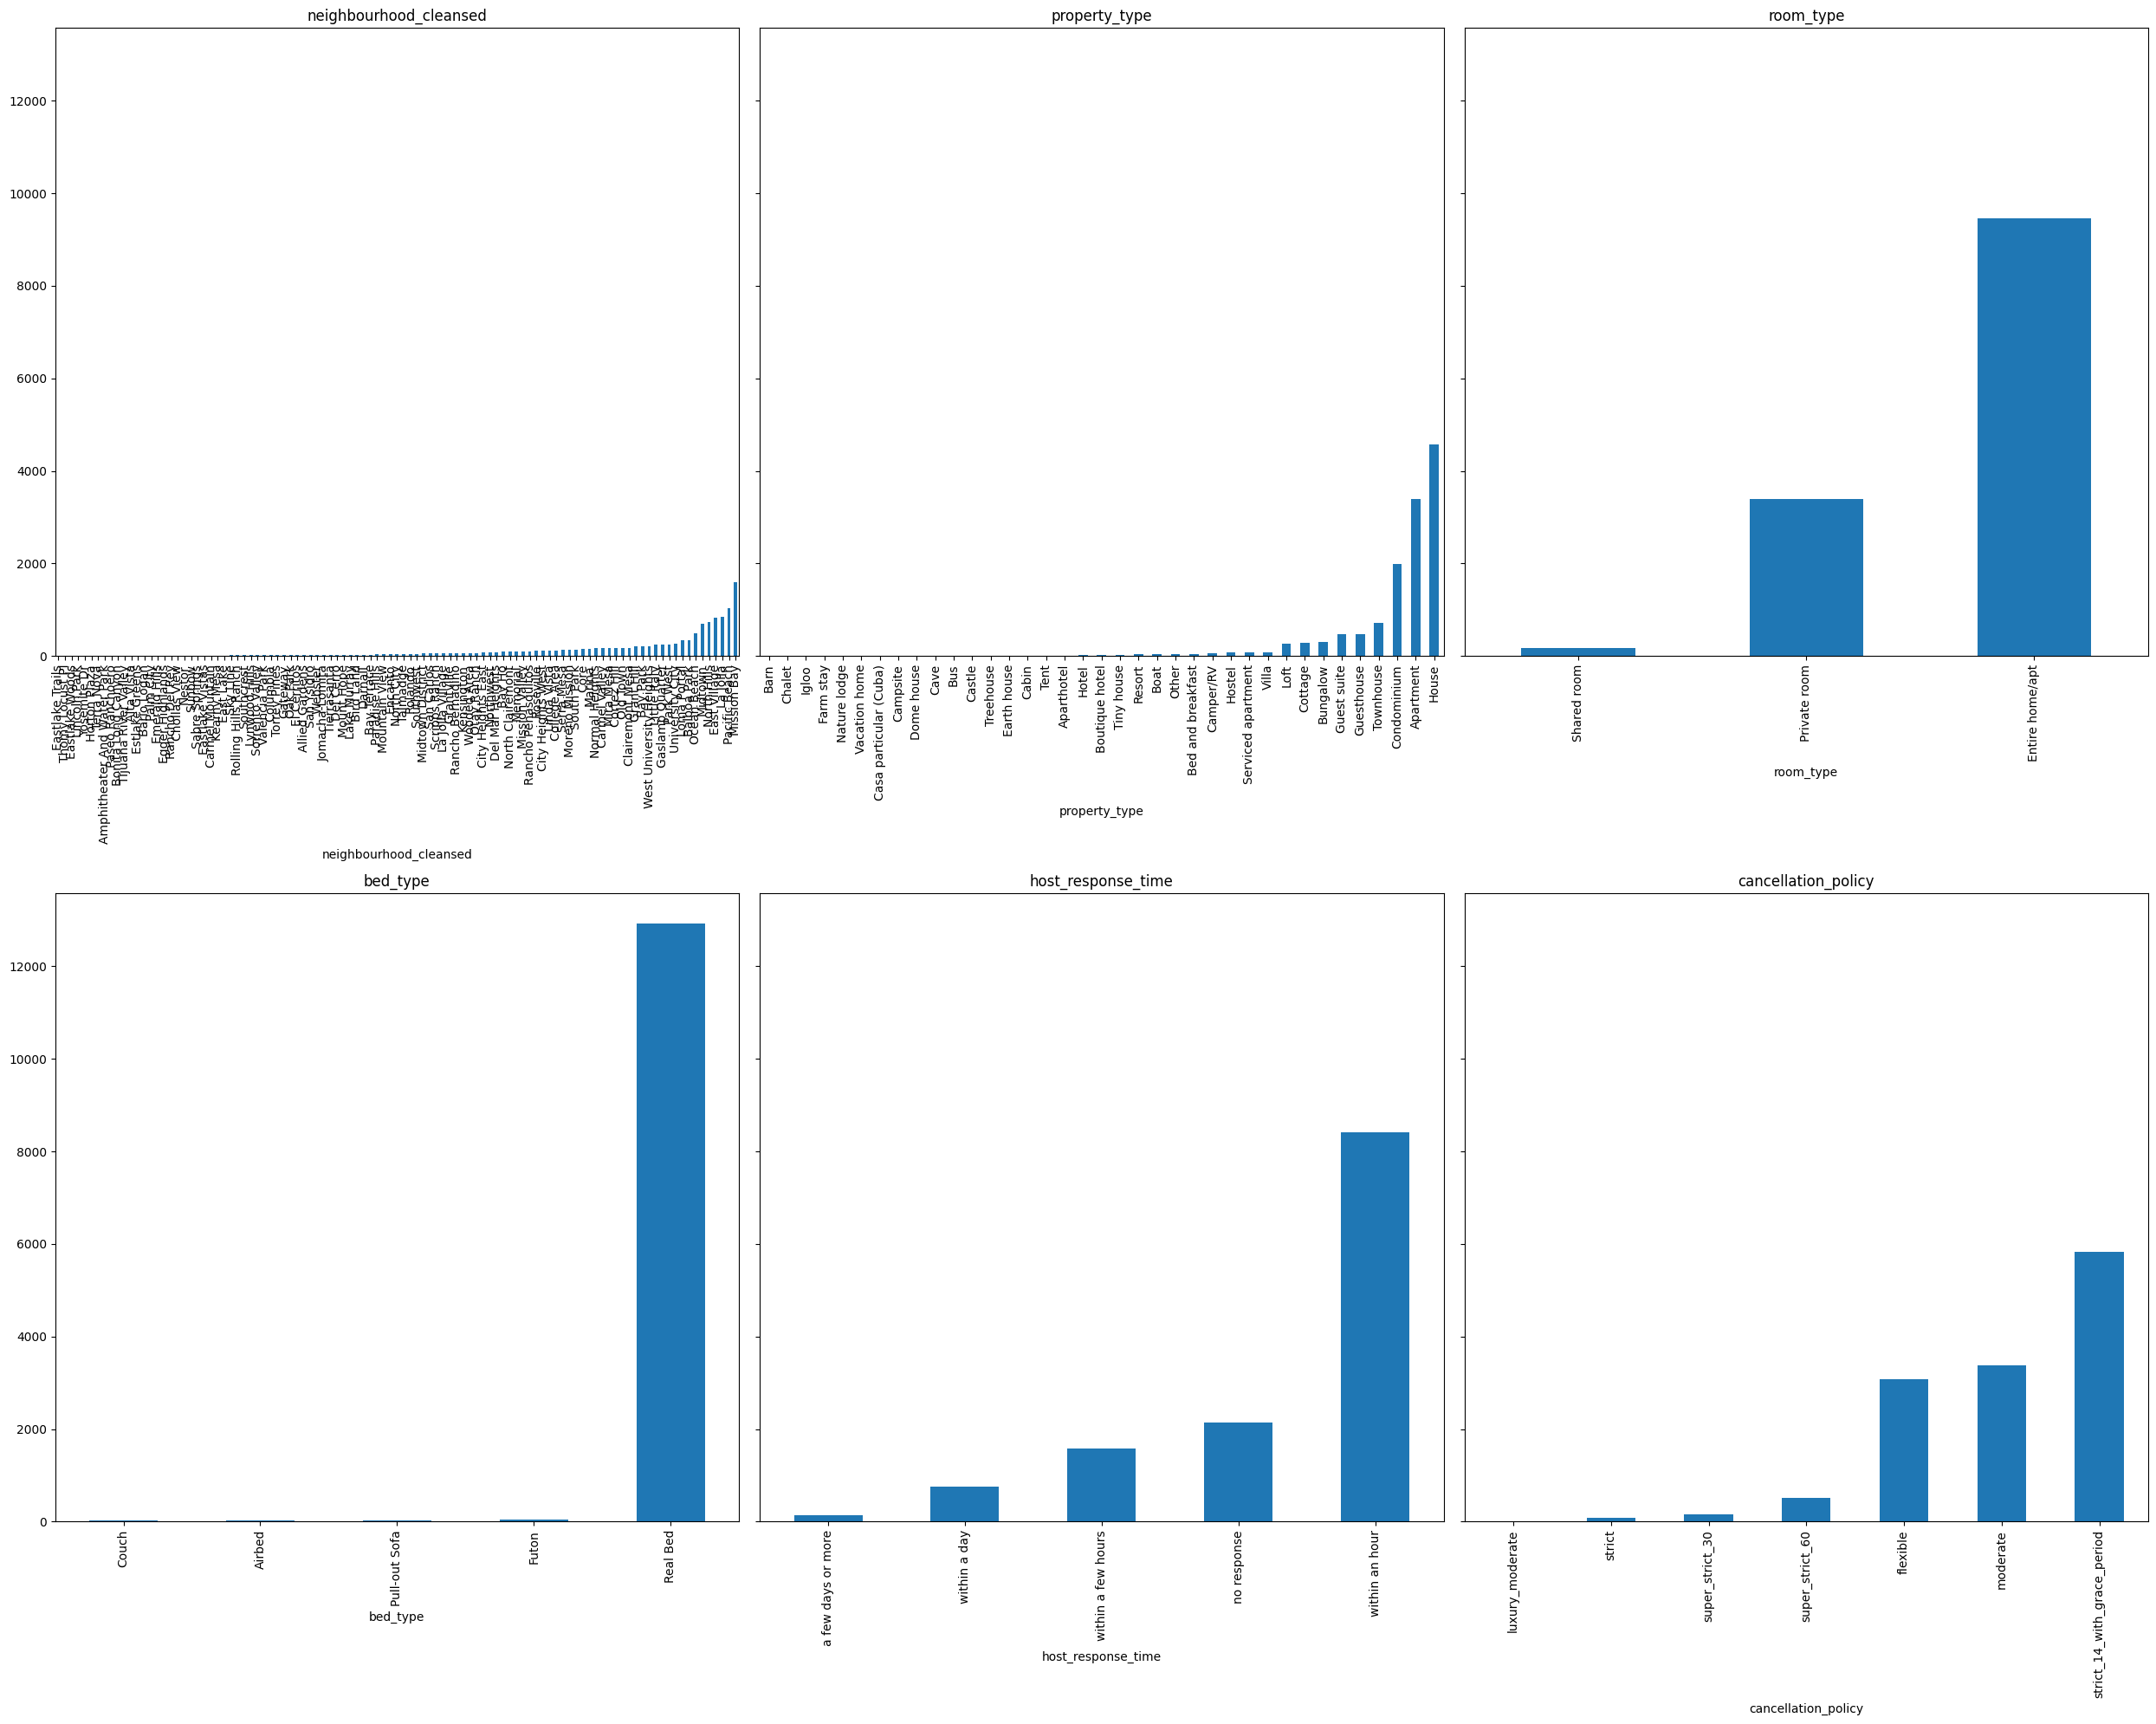

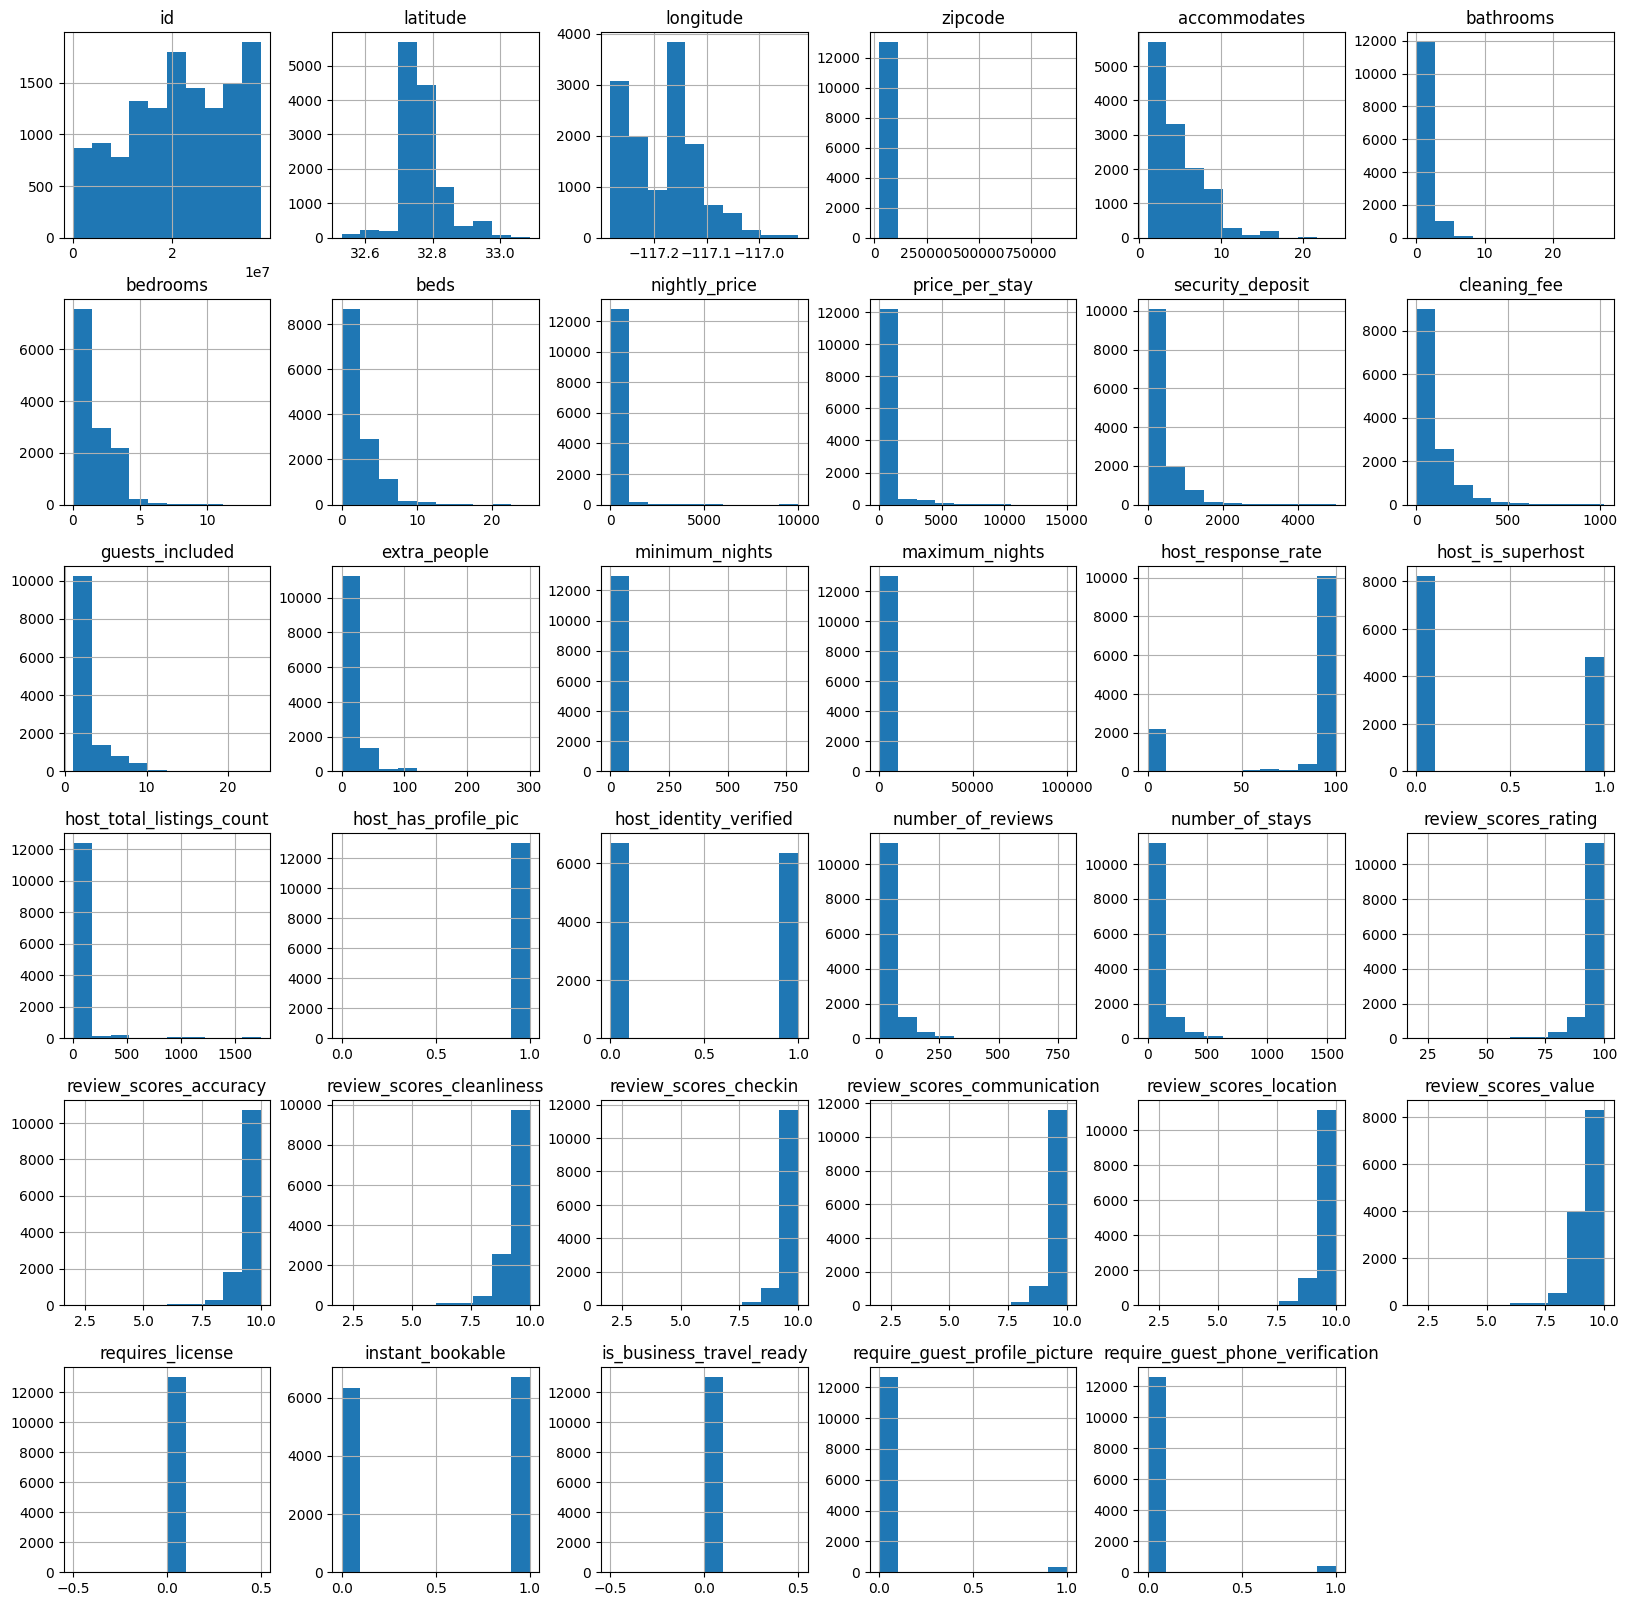

In [23]:
sd_modeling.hist(figsize = (20,20))
plt.show()

-- Çoğu sayısal özellik sağa doğru uzun bir kuyruk yapısına sahiptir (yani, sağa çarpık) ve normal dağılım göstermez. Örneğin, yatak odası sayısının sağa doğru uzun bir kuyruğa sahip olması beklenir, çünkü çoğu insan muhtemelen 2 yatak odasından daha az odalı listelemeler arayacaktır.

## Correlations Between Features

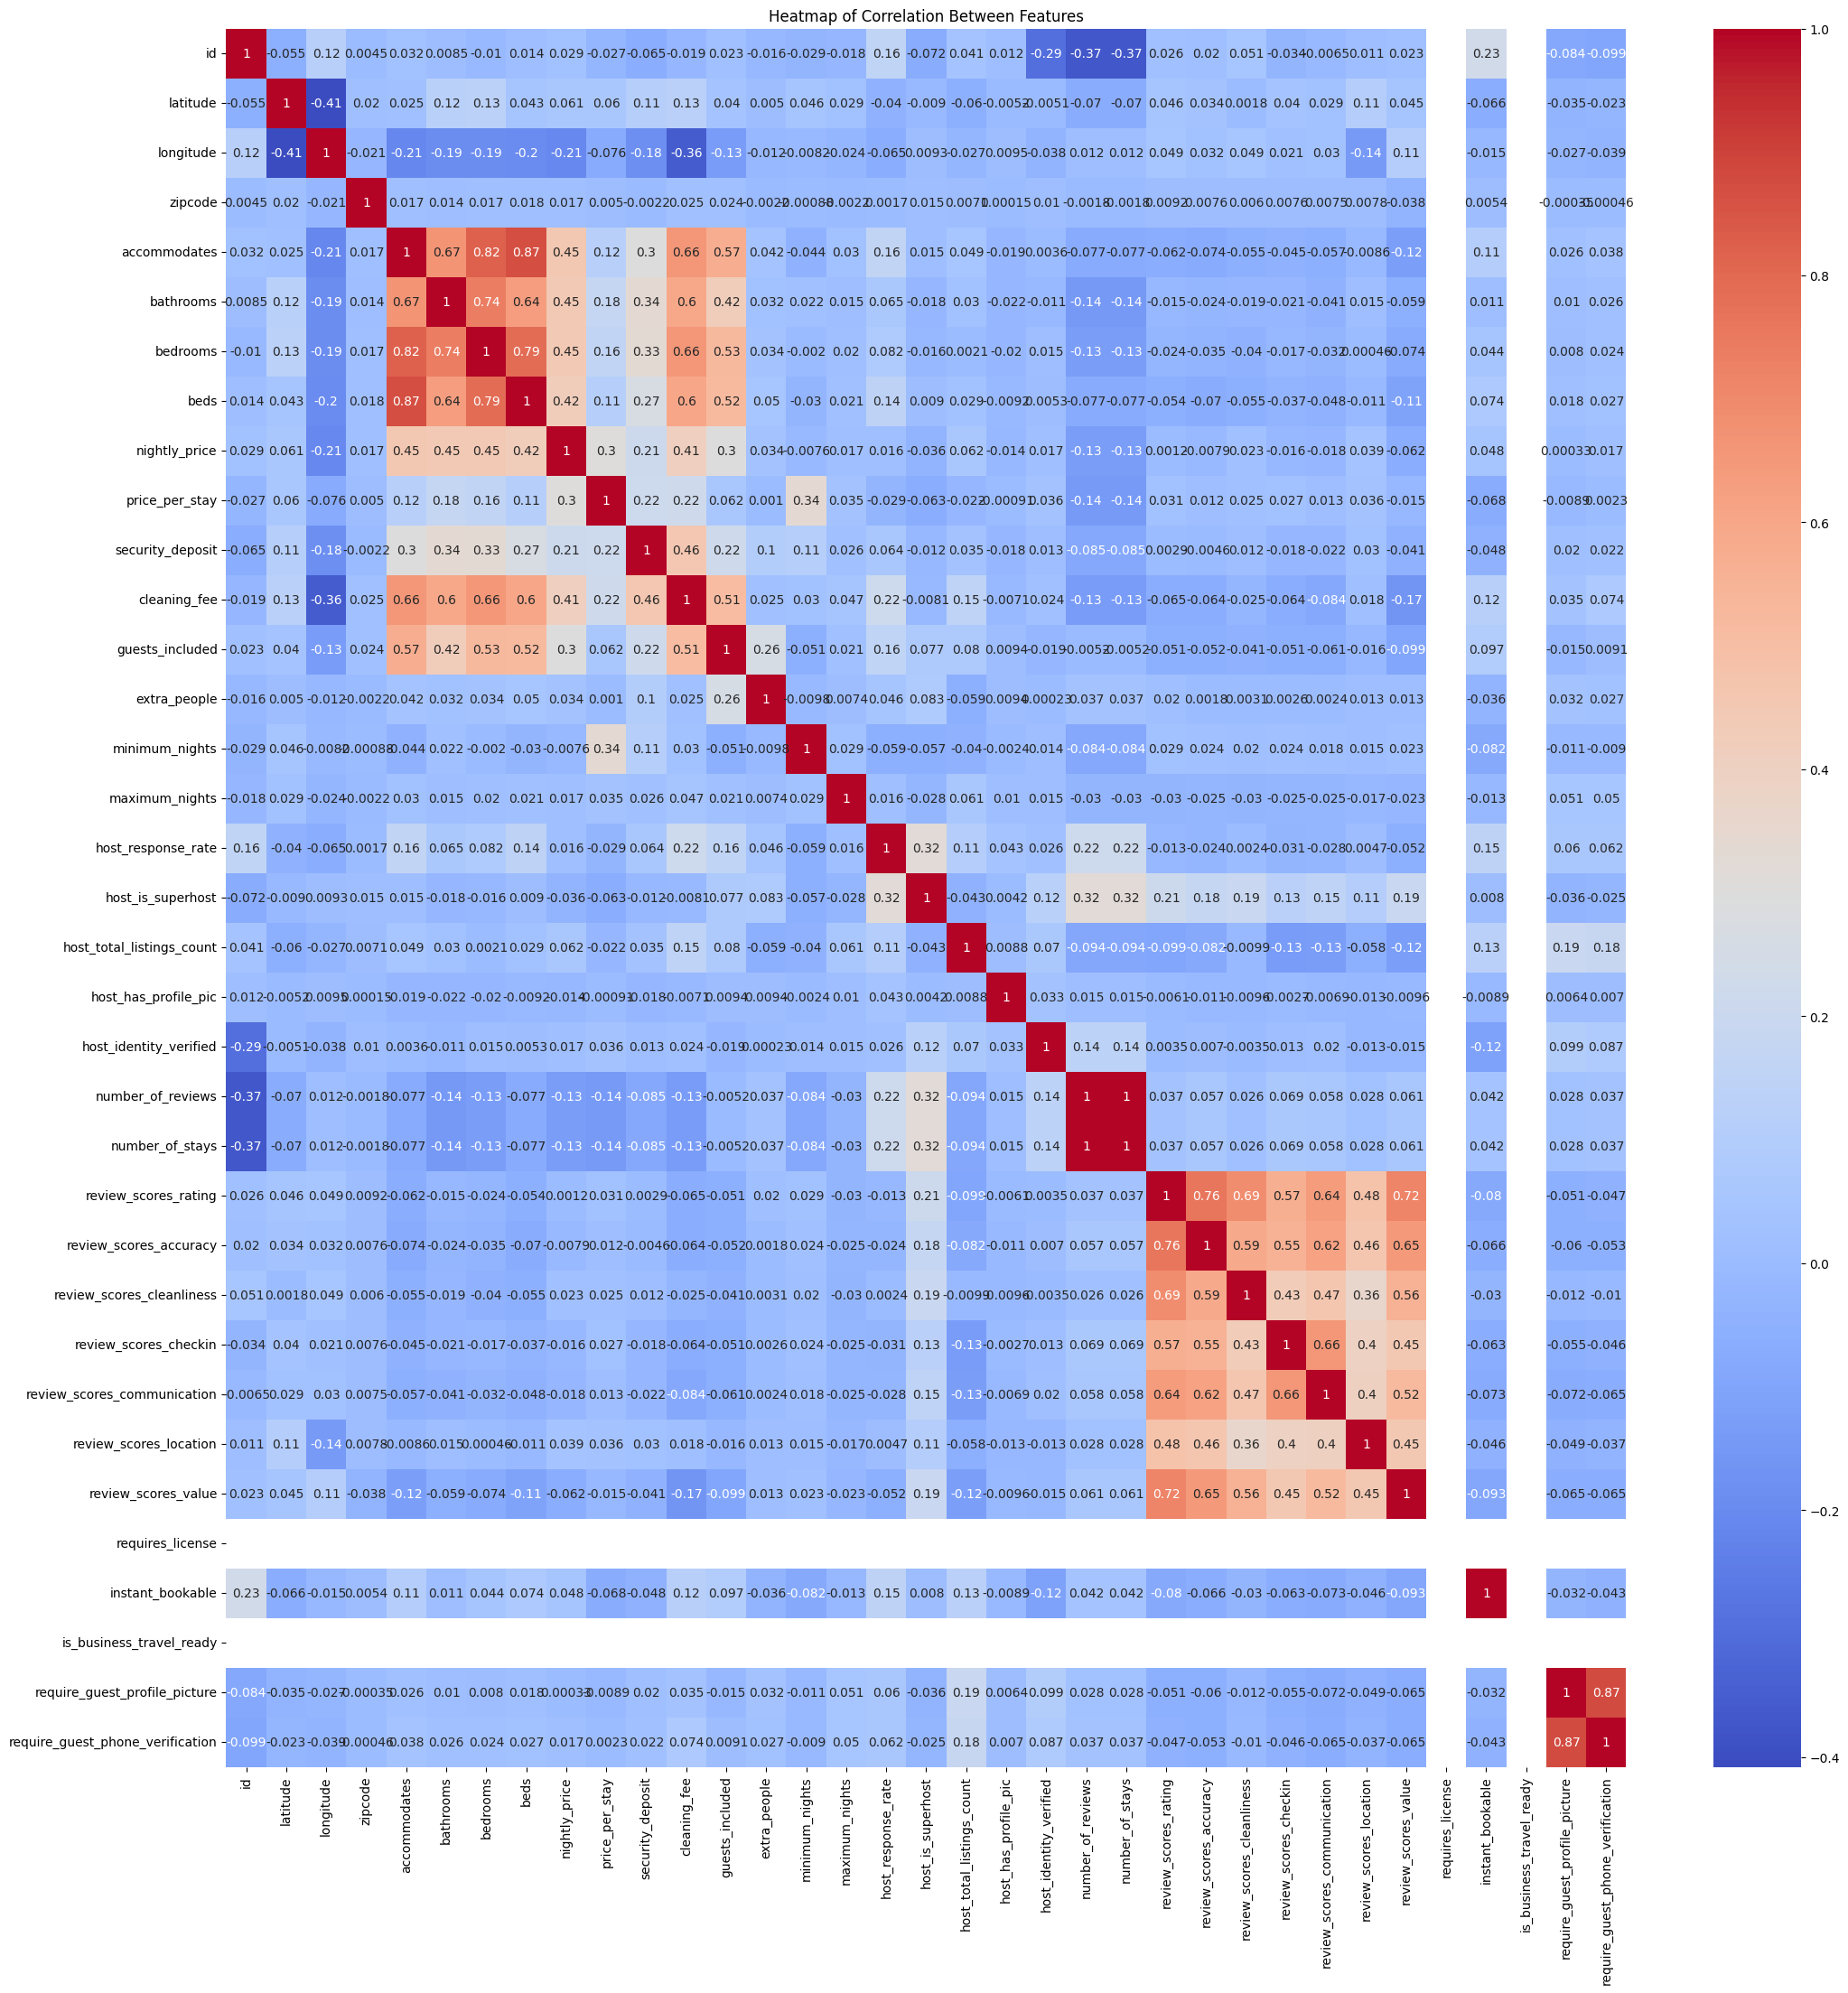

In [24]:
# set up figure size
fig, ax = plt.subplots(figsize=(25, 25))

# select only numerical columns
numeric_cols = sd_modeling.select_dtypes(include=[float, int])

# set up correlation matrix
corr = numeric_cols.corr()

# plot the heatmap
sns.heatmap(corr, cmap='coolwarm', annot=True)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Features")

plt.show()


-Yatak sayısı, banyo sayısı ve yatak odası sayısı arasında güçlü bir korelasyonel ilişki vardır. Bu özellikler ayrıca fiyat, yani gecelik fiyat üzerinde de en güçlü göstergeler gibi görünmektedir.

-Beklendiği gibi, inceleme puanları (rating, accuracy, cleanliness vb.) arasında da korelasyonlar bulunmaktadır.

## Preprocessing Features

### Categorical features

In [25]:
cat_cols

['neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type',
 'host_response_time',
 'cancellation_policy']

zipcode'ı  OHE (One-Hot Encoding) yapılması gereken nominal bir özellik olarak ekliycez

In [26]:
# zipcode'ı OHE (One-Hot Encoding) için bir dtype nesnesine (object) dönüştür
sd_modeling['zipcode'] = sd_modeling['zipcode'].astype(object)

#### Sıralı (ordinal) sütunların sırasını belirleme

In [27]:
# Veriyi kategorik (categorical) veri tipine dönüştür
sd_modeling['host_response_time'] = sd_modeling['host_response_time'].astype('category')
sd_modeling['cancellation_policy'] = sd_modeling['cancellation_policy'].astype('category')

In [28]:
# Ordinal özelliklerin sırasını tanımla
response_time_list = ['within an hour',
                      'within a few hours', 
                      'within a day', 
                      'a few days or more', 
                      'no response']

cancellation_policy_list = ['flexible',
                            'moderate',
                            'strict',
                            'strict_14_with_grace_period', 
                            'super_strict_60', 
                            'super_strict_30',
                            'luxury_moderate']

In [29]:
# Kategorik sütunlardaki nominal ve ordinal özellikleri tanımla
nom_cols = sd_modeling.select_dtypes(['object']).columns
print(nom_cols)
ordinal_cols = sd_modeling.select_dtypes(['category']).columns
print(ordinal_cols)

Index(['neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type',
       'bed_type'],
      dtype='object')
Index(['host_response_time', 'cancellation_policy'], dtype='object')


cancellation_policy'nin ordinal sıralaması hakkında daha fazla bilgi için <a href = 'https://www.airbnb.com/help/article/475/cancellation-policies-for-your-listing'>Airbnb'nin iptal politikalarına</a> başvurun.
For more information on the ordinal ranking of `cancellation_policy`; refer to <a href = 'https://www.airbnb.com/help/article/475/cancellation-policies-for-your-listing'> Airbnb's cancellation policies</a>.

### Pipeline dönüştürücüsü oluşturma

In [30]:
# Sayıları ölçeklendiren sayısal dönüşüm pipeline'ını tanımla
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) 

# Kategorileri sıralı bir şekilde kodlayan bir sıralı dönüşüm pipeline'ı tanımla
ordinal_pipeline = Pipeline([('ordinalenc', OrdinalEncoder(categories = [response_time_list, 
                                                                         cancellation_policy_list]))])

# Kategorileri One-Hot Encoding (OHE) ile kodlayan bir nominal dönüşüm pipeline'ı tanımla
nominal_pipeline = Pipeline([('onehotenc', OneHotEncoder(categories= "auto", 
                                                         sparse_output = False, 
                                                         handle_unknown = 'ignore'))])

Önişlemeye sunulucak yeni veri setini tanımla

In [31]:
sd_trans = sd_modeling.drop(columns = ['id', 'latitude', 'longitude'])
sd_trans = sd_trans.reset_index(drop = 'index')
sd_trans.head()

neighbourhood_cleansed zipcode property_type        room_type  accommodates  \
0          Scripps Ranch   92131         House     Private room             1   
1               La Jolla   92037     Apartment  Entire home/apt             1   
2          Pacific Beach   92109     Townhouse     Private room             1   
3           College Area   92120     Apartment  Entire home/apt             1   
4               La Jolla   92037   Condominium     Private room             1   

   bathrooms  bedrooms  beds  bed_type  nightly_price  price_per_stay  \
0        1.0       1.0     1  Real Bed         1100.0          1100.0   
1        2.0       2.0     3  Real Bed         1400.0          1400.0   
2        1.0       1.0     1  Real Bed         1250.0          1250.0   
3        1.0       1.0     1  Real Bed         1150.0          1150.0   
4        1.0       1.0     1  Real Bed          110.0           110.0   

   security_deposit  cleaning_fee  guests_included  extra_people  \
0            1000.0           0.0                1           0.0   
1               0.0           0.0                1           0.0   
2               0.0           0.0                1           0.0   
3               0.0           0.0                1           0.0   
4             200.0           0.0                1          50.0   

   minimum_nights  maximum_nights  host_response_time  host_response_rate  \
0              60              90  within a few hours               100.0   
1              30            1125         no response                 0.0   
2              30              30         no response                 0.0   
3              31              40         no response                 0.0   
4             180             365        within a day                67.0   

   host_is_superhost  host_total_listings_count  host_has_profile_pic  \
0                  0                        1.0                     1   
1                  0                        1.0                     1   
2                  0                        1.0                     1   
3                  0                        1.0                     1   
4                  0                        6.0                     1   

   host_identity_verified  number_of_reviews  number_of_stays  \
0                       0                  0                0   
1                       0                  2                4   
2                       0                  0                0   
3                       0                  0                0   
4                       1                  2                4   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                  98.0                    10.0                       10.0   
1                 100.0                    10.0                       10.0   
2                  97.0                    10.0                       10.0   
3                  98.0                    10.0                       10.0   
4                  90.0                     7.0                        7.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                   10.0                         10.0                    10.0   
4                    8.0                          8.0                     9.0   

   review_scores_value  requires_license  instant_bookable  \
0                 10.0                 0                 1   
1                 10.0                 0                 1   
2                 10.0                 0                 1   
3                 10.0                 0                 0   
4                 10.0                 0                 0   

   is_business_travel_ready          cancella

In [32]:
#Seçilen sütunlar için pipelinelarla birlikte sütun dönüştürücüsünü oluştur
ct = ColumnTransformer(transformers = [("nominalpipe", nominal_pipeline, ['neighbourhood_cleansed',
                                                                            'zipcode', 'property_type', 
                                                                            'room_type','bed_type']),
                                       ("ordinalpipe", ordinal_pipeline, ['host_response_time', 
                                                                          'cancellation_policy']),
                                       ("numericpipe", numeric_pipeline, sd_modeling.select_dtypes(['int', 'float']).columns)])


In [33]:
# save the column transformer
import os
from pickle import dump

# 'pkl' dizinini oluştur
os.makedirs('pkl', exist_ok=True)

# column transformer'ı kaydet
dump(ct, open('pkl/column_transformer.pkl', 'wb'))


#### Özellik adı alımının basitleştirilmesi için veri çerçevesinin sıralanması

In [34]:
# Veri çerçevesini önce nominal, sonra ordinal, son olarak da geri kalan sayısal verilerle sıralayın

sd_trans = sd_trans[ # nominal below this line
                    ['neighbourhood_cleansed','zipcode', 'property_type', 'room_type','bed_type',
                     # ordinal below this line
                     'host_response_time', 'cancellation_policy', 
                     # remaining numeric
                     'accommodates', 'bathrooms', 'bedrooms', 'beds','nightly_price', 'price_per_stay', 
                     'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights', 
                     'maximum_nights', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                     'host_has_profile_pic','host_identity_verified', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 
                     'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                     'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                     'requires_license', 'instant_bookable', 'is_business_travel_ready',
                     'require_guest_profile_picture', 'require_guest_phone_verification']]

In [35]:
sd_trans.head()

neighbourhood_cleansed zipcode property_type        room_type  bed_type  \
0          Scripps Ranch   92131         House     Private room  Real Bed   
1               La Jolla   92037     Apartment  Entire home/apt  Real Bed   
2          Pacific Beach   92109     Townhouse     Private room  Real Bed   
3           College Area   92120     Apartment  Entire home/apt  Real Bed   
4               La Jolla   92037   Condominium     Private room  Real Bed   

   host_response_time          cancellation_policy  accommodates  bathrooms  \
0  within a few hours  strict_14_with_grace_period             1        1.0   
1         no response  strict_14_with_grace_period             1        2.0   
2         no response                     flexible             1        1.0   
3         no response                     flexible             1        1.0   
4        within a day  strict_14_with_grace_period             1        1.0   

   bedrooms  beds  nightly_price  price_per_stay  security_deposit  \
0       1.0     1         1100.0          1100.0            1000.0   
1       2.0     3         1400.0          1400.0               0.0   
2       1.0     1         1250.0          1250.0               0.0   
3       1.0     1         1150.0          1150.0               0.0   
4       1.0     1          110.0           110.0             200.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0                1           0.0              60   
1           0.0                1           0.0              30   
2           0.0                1           0.0              30   
3           0.0                1           0.0              31   
4           0.0                1          50.0             180   

   maximum_nights  host_response_rate  host_is_superhost  \
0              90               100.0                  0   
1            1125                 0.0                  0   
2              30                 0.0                  0   
3              40                 0.0                  0   
4             365                67.0                  0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                     1                       0   
1                        1.0                     1                       0   
2                        1.0                     1                       0   
3                        1.0                     1                       0   
4                        6.0                     1                       1   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                  0                0                  98.0   
1                  2                4                 100.0   
2                  0                0                  97.0   
3                  0                0                  98.0   
4                  2                4                  90.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                     7.0                        7.0                    8.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                         10.0                    10.0                 10.0   
4                          8.0                     9.0                 10.0   

   requires_license  instant_bookable  is_business_travel_ready  \
0                 0 

In [36]:
sd_trans.shape

(13040, 38)

In [37]:
# save as csv
path = "data/"

sd_trans.to_csv(path + 'sd_trans')

### Transforming 

In [38]:
print(sd_trans.columns)


Index(['neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type',
       'bed_type', 'host_response_time', 'cancellation_policy', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'nightly_price', 'price_per_stay',
       'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people',
       'minimum_nights', 'maximum_nights', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'number_of_reviews',
       'number_of_stays', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'requires_license', 'instant_bookable',
       'is_business_travel_ready', 'require_guest_profile_picture',
       'require_guest_phone_verification'],
      dtype='object')


In [39]:
ct = ColumnTransformer(transformers = [
    # Nominal (kategorik) değişkenler için pipeline
    ("nominalpipe", nominal_pipeline, ['neighbourhood_cleansed', 'zipcode', 'property_type', 'room_type', 'bed_type']),
    
    # Ordinal (kategorik sıralı) değişkenler için pipeline
    ("ordinalpipe", ordinal_pipeline, ['host_response_time', 'cancellation_policy']),
    
    # Numeric (sayısal) değişkenler için pipeline
    ("numericpipe", numeric_pipeline, ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'nightly_price', 
                                       'price_per_stay', 'security_deposit', 'cleaning_fee', 'guests_included', 
                                       'extra_people', 'minimum_nights', 'maximum_nights', 'host_response_rate',
                                       'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic',
                                       'host_identity_verified', 'number_of_reviews', 'number_of_stays', 
                                       'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                                       'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                                       'review_scores_value', 'requires_license', 'instant_bookable', 
                                       'is_business_travel_ready', 'require_guest_profile_picture',
                                       'require_guest_phone_verification'])
])


In [40]:
sd_pp = pd.DataFrame(ct.fit_transform(sd_trans))

# Dönüştürülen veriyi kaydetmek için pkl dosyası oluşturma
import os
if not os.path.exists('pkl'):
    os.makedirs('pkl')

dump(ct, open('pkl/column_transformer.pkl', 'wb'))

In [41]:
sd_pp = pd.DataFrame(ct.fit_transform(sd_trans))

In [42]:
sd_pp.head()

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   

   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   90   91   92   93   94   95   96   97   98   99   100  101  102  103  104  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  \
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

#### Özellik adlarını alın ve sd_pp'ye atayın.`sd_pp`

In [43]:
# get nominal values
nominal_features = list(nominal_pipeline.named_steps['onehotenc'].fit(sd_trans[nom_cols]).get_feature_names_out())


In [44]:
nominal_features[0:5]

['neighbourhood_cleansed_Allied Gardens',
 'neighbourhood_cleansed_Alta Vista',
 'neighbourhood_cleansed_Amphitheater And Water Park',
 'neighbourhood_cleansed_Balboa Park',
 'neighbourhood_cleansed_Bario Logan']

##### Cleaning feature names

In [45]:
ordinal_list = list(ordinal_cols)
ordinal_list 

['host_response_time', 'cancellation_policy']

In [46]:
numeric_list = ['accommodates', 'bathrooms', 'bedrooms', 'beds','nightly_price', 'price_per_stay', 
                     'security_deposit', 'cleaning_fee','guests_included', 'extra_people', 'minimum_nights', 
                     'maximum_nights', 'host_response_rate', 'host_is_superhost', 'host_total_listings_count', 
                     'host_has_profile_pic','host_identity_verified', 'number_of_reviews', 'number_of_stays', 'review_scores_rating', 
                     'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
                     'review_scores_communication', 'review_scores_location', 'review_scores_value', 
                     'requires_license', 'instant_bookable', 'is_business_travel_ready',
                     'require_guest_profile_picture', 'require_guest_phone_verification']
len(numeric_list)

31

In [47]:
features_to_clean = ['x0_Allied Gardens', 'x0_Alta Vista', 'x0_Amphitheater And Water Park', 'x0_Balboa Park',
                   'x0_Bario Logan', 'x0_Bay Ho', 'x0_Bay Park', 'x0_Bay Terrace', 'x0_Bird Land',
                   'x0_Bonita Long Canyon', 'x0_Carmel Mountain', 'x0_Carmel Valley', 'x0_Chollas View',
                   'x0_City Heights East', 'x0_City Heights West', 'x0_Clairemont Mesa', 'x0_College Area',
                   'x0_Columbia', 'x0_Core', 'x0_Cortez Hill', 'x0_Darnall', 'x0_Del Cerro',
                   'x0_Del Mar Heights', 'x0_East Lake', 'x0_East Village', 'x0_Eastlake Trails',
                   'x0_Eastlake Vistas', 'x0_Eastlake Woods', 'x0_Egger Highlands', 'x0_El Cerritos',
                   'x0_Emerald Hills', 'x0_Encanto', 'x0_Estlake Greens', 'x0_Gaslamp Quarter', 'x0_Gateway',
                   'x0_Grant Hill', 'x0_Grantville', 'x0_Horton Plaza', 'x0_Jomacha-Lomita', 'x0_Kearny Mesa',
                   'x0_Kensington', 'x0_La Jolla', 'x0_La Jolla Village', 'x0_Lake Murray', 'x0_Lincoln Park',
                   'x0_Linda Vista', 'x0_Little Italy', 'x0_Loma Portal', 'x0_Lynwood Hills', 'x0_Marina',
                   'x0_Memorial', 'x0_Midtown', 'x0_Midtown District', 'x0_Mira Mesa', 'x0_Mission Bay',
                   'x0_Mission Valley', 'x0_Moreno Mission', 'x0_Mount Hope', 'x0_Mountain View', 'x0_Nestor',
                   'x0_Normal Heights', 'x0_North City', 'x0_North Clairemont', 'x0_North Hills',
                   'x0_Northwest', 'x0_Oak Park', 'x0_Ocean Beach', 'x0_Old Town', 'x0_Otay Ranch',
                   'x0_Pacific Beach', 'x0_Palm City', 'x0_Paradise Hills', 'x0_Park West',
                   'x0_Paseo Ranchoero', 'x0_Rancho Bernadino', 'x0_Rancho Del Rey', 'x0_Rancho Penasquitos',
                   'x0_Rolando', 'x0_Rolling Hills Ranch', 'x0_Roseville', 'x0_Sabre Springs', 'x0_San Carlos',
                   'x0_San Ysidro', 'x0_Scripps Ranch', 'x0_Serra Mesa', 'x0_Sky Line', 'x0_Sorrento Valley',
                   'x0_South Park', 'x0_Southcrest', 'x0_Southwest', 'x0_Sunbow', 'x0_Talmadge',
                   'x0_Terra Nova', 'x0_Thomy Locust Pl', 'x0_Tierrasanta', 'x0_Tijuana River Valley',
                   'x0_Torrey Pines', 'x0_University City', 'x0_Valencia Park', 'x0_Webster',
                   'x0_West University Heights', 'x0_Wooded Area', 'x0_Yosemite Dr', 'x1_22000', 'x1_22010',
                   'x1_22425', 'x1_22435', 'x1_91901', 'x1_91902', 'x1_91910', 'x1_91911', 'x1_91913',
                   'x1_91914', 'x1_91915', 'x1_91932', 'x1_91941', 'x1_91942', 'x1_91945', 'x1_91950',
                   'x1_92014', 'x1_92025', 'x1_92029', 'x1_92037', 'x1_92054', 'x1_92064', 'x1_92071',
                   'x1_92075', 'x1_92101', 'x1_92102', 'x1_92103', 'x1_92104', 'x1_92105', 'x1_92106',
                   'x1_92107', 'x1_92108', 'x1_92109', 'x1_92110', 'x1_92111', 'x1_92113', 'x1_92114',
                   'x1_92115', 'x1_92116', 'x1_92117', 'x1_92118', 'x1_92119', 'x1_92120', 'x1_92121',
                   'x1_92122', 'x1_92123', 'x1_92124', 'x1_92126', 'x1_92127', 'x1_92128', 'x1_92129',
                   'x1_92130', 'x1_92131', 'x1_92139', 'x1_92154', 'x1_92173', 'x1_92307', 'x1_92618',
                   'x1_921096', 'x2_Aparthotel', 'x2_Apartment', 'x2_Barn', 'x2_Bed and breakfast', 'x2_Boat',
                   'x2_Boutique hotel', 'x2_Bungalow', 'x2_Bus', 'x2_Cabin', 'x2_Camper/RV', 'x2_Campsite',
                   'x2_Casa particular (Cuba)', 'x2_Castle', 'x2_Cave', 'x2_Chalet', 'x2_Condominium',
                   'x2_Cottage', 'x2_Dome house', 'x2_Earth house', 'x2_Farm stay', 'x2_Guest suite',
                   'x2_Guesthouse', 'x2_Hostel', 'x2_Hotel', 'x2_House', 'x2_Igloo', 'x2_Loft',
                   'x2_Nature lodge', 'x2_Other', 'x2_Resort', 'x2_Serviced apartment', 'x2_Tent',
                   'x2_Tiny house', 'x2_Townhouse', 'x2_Treehouse', 'x2_Vacation home', 'x2_Villa',
                   'x3_Entire home/apt', 'x3_Private room', 'x3_Shared room', 'x4_Airbed', 'x4_Couch',
                   'x4_Futon', 'x4_Pull-out Sofa', 'x4_Real Bed']

In [48]:
# Özellik adlarının önündeki OHE (One-Hot Encoding) dizilerini kaldırır
def clean_features(lst):
    new_list = []
    for value in lst:
        splitted = value.split('_')[1] # Özelliğin adını '_' karakterinden sonrasını döndürür.
        new_list.append(splitted)
        continue
    return new_list

In [49]:
cleaned_features = clean_features(features_to_clean)

In [50]:
sd_pp.columns = cleaned_features + ordinal_list + numeric_list
sd_pp

Allied Gardens  Alta Vista  Amphitheater And Water Park  Balboa Park  \
0                 0.0         0.0                          0.0          0.0   
1                 0.0         0.0                          0.0          0.0   
2                 0.0         0.0                          0.0          0.0   
3                 0.0         0.0                          0.0          0.0   
4                 0.0         0.0                          0.0          0.0   
...               ...         ...                          ...          ...   
13035             0.0         0.0                          0.0          0.0   
13036             0.0         0.0                          0.0          0.0   
13037             0.0         0.0                          0.0          0.0   
13038             0.0         0.0                          0.0          0.0   
13039             0.0         0.0                          0.0          0.0   

       Bario Logan  Bay Ho  Bay Park  Bay Terrace  Bird Land  \
0              0.0     0.0       0.0          0.0        0.0   
1              0.0     0.0       0.0          0.0        0.0   
2              0.0     0.0       0.0          0.0        0.0   
3              0.0     0.0       0.0          0.0        0.0   
4              0.0     0.0       0.0          0.0        0.0   
...            ...     ...       ...          ...        ...   
13035          0.0     0.0       0.0          0.0        0.0   
13036          0.0     0.0       0.0          0.0        0.0   
13037          0.0     0.0       0.0          0.0        0.0   
13038          0.0     0.0       0.0          0.0        0.0   
13039          0.0     0.0       0.0          0.0        0.0   

       Bonita Long Canyon  Carmel Mountain  Carmel Valley  Chollas View  \
0                     0.0              0.0            0.0           0.0   
1                     0.0              0.0            0.0           0.0   
2                     0.0              0.0            0.0           0.0   
3                     0.0              0.0            0.0           0.0   
4                     0.0              0.0            0.0           0.0   
...                   ...              ...            ...           ...   
13035                 0.0              0.0            0.0           0.0   
13036                 0.0              0.0            0.0           0.0   
13037                 0.0              0.0            0.0           0.0   
13038                 0.0              0.0            0.0           0.0   
13039                 0.0              0.0            0.0           0.0   

       City Heights East  City Heights West  Clairemont Mesa  College Area  \
0                    0.0                0.0              0.0           0.0   
1                    0.0                0.0              0.0           0.0   
2                    0.0                0.0              0.0           0.0   
3                    0.0                0.0              0.0           1.0   
4                    0.0                0.0              0.0           0.0   
...                  ...                ...              ...           ...   
13035                0.0                0.0              0.0           0.0   
13036                0.0                0.0              0.0           0.0   
13037                0.0                0.0              0.0           0.0   
13038                0.0                0.0              0.0           0.0   
13039                0.0                0.0              0.0           0.0   

       Columbia  Core  Cortez Hill  Darnall  Del Cerro  Del Mar Heights  \
0           0.0   0.0          0.0      0.0        0.0              0.0   
1           0.0   0.0          0.0      0.0        0.0              0.0   
2           0.0   0.0          0.0      0.0        0.0              0.0   
3           0.0   0.0          0.0      0.0        0.0              0.0   
4           0.0   0.0          0.0      0.0        0.0              0.0   
.

In [51]:
# save as csv
path = "data/"

sd_pp.to_csv(path + 'sd_pp')

## Kümeleme: Ön İşlemden Geçirilmiş Verinin Görselleştirilmesi Clustering: Visualizing The Pre-Processed Dataset

<a href = 'https://umap-learn.readthedocs.io/en/latest/'> UMAP </a>  kullanarak, ön işlemden geçmiş veriyi görselleştirmeye çalışacağız. UMAP olmadan, veri kümesindeki çok boyutlu özellikleri görselleştirmek zor olurdu.

In [52]:
import umap

In [53]:
print("derya")

derya


In [54]:
import umap

In [55]:
import umap

embedding = umap.UMAP(n_neighbors=500, min_dist=0.9).fit_transform(sd_pp)


In [56]:
import sys
print(sys.executable)


c:\ProgramData\anaconda3\envs\python310\python.exe


In [57]:
#Bu işlem, embedding verisini daha sonra hızlıca yükleyebilmek için kaydeder. 
#.npy formatı, NumPy dizileri için optimize edilmiştir, böylece dosya doğrudan NumPy ile kolayca okunabilir ve işlenebilir.
np.save('data/embedding_plot.npy', embedding)

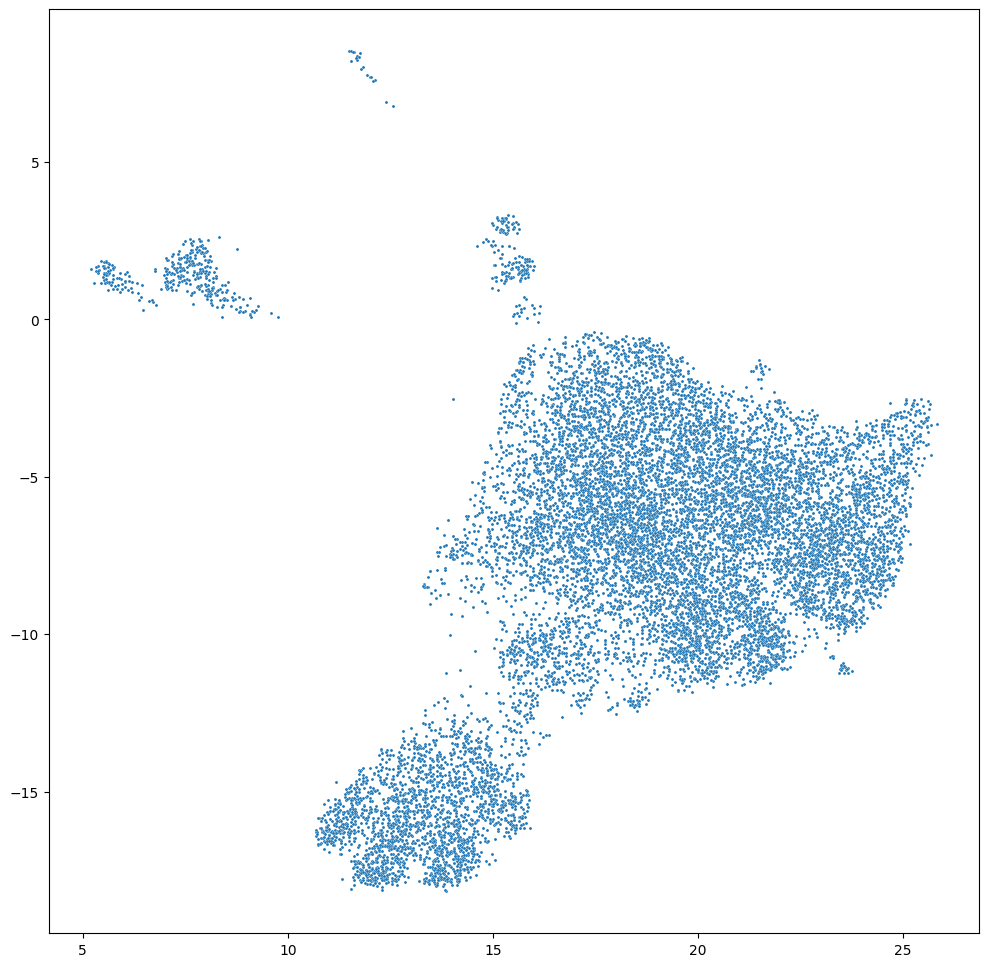

In [58]:
embedding = np.load('data/embedding_plot.npy')

fig, ax = plt.subplots(figsize=(12, 12))
# x ve y eksenlerini ayrı ayrı geçiyoruz
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], s=5, alpha=1)

plt.show()


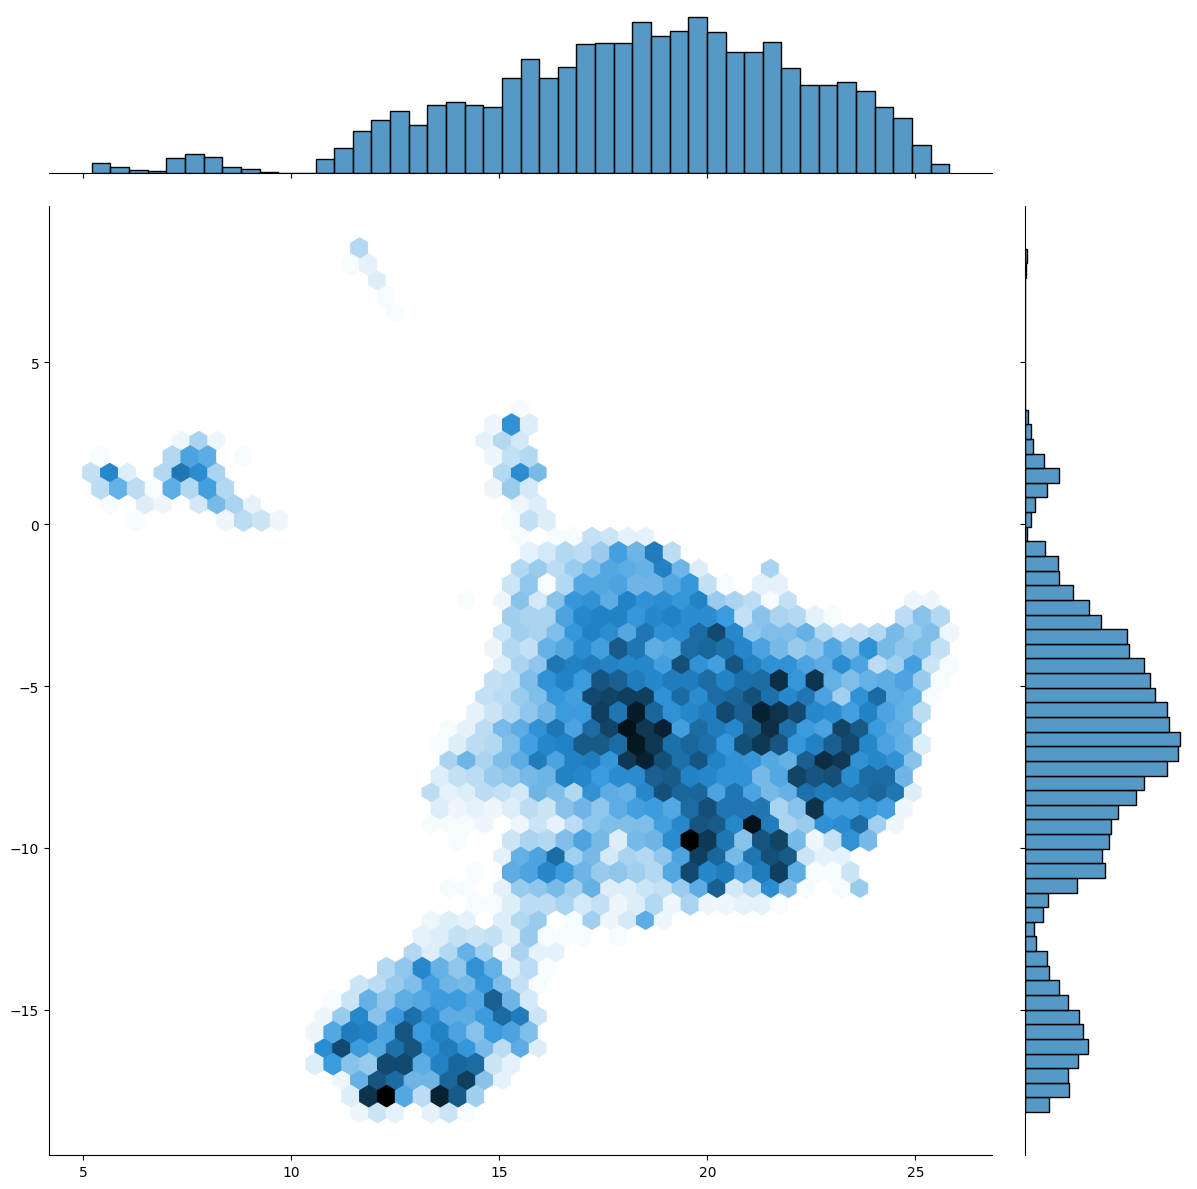

In [59]:
embedding = np.load('data/embedding_plot.npy')

# x ve y eksenlerini ayrı ayrı belirtelim
sns.jointplot(x=embedding[:, 0], y=embedding[:, 1], kind='hex', height=12)

plt.show()


### N-Küme Sayısını Bulma - Finding N-Clusters

In [60]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

In [61]:
# # tahmin edilen kümeleme sonuçlarını depolar
# results=[]
# kmeans_predictions = []

# # k = 2'den 40'a kadar bir kümeleme aralığı için yineleme yapar
# for k in range(2, 41):
#     kmeans = MiniBatchKMeans(n_clusters=k).fit(sd_pp)
#     predict = kmeans.predict(sd_pp)
#     result = {
#         'k':k,
#         'inertia': kmeans.inertia_,                      # Her k iterasyonu için atalet puanını alır.
#         'silhouette': silhouette_score(sd_pp, predict),  # silhouette skorunu al
#     }
#     results.append(result)
#     kmeans_predictions.append(predict)
#     print(result, end='\r')
    
# cluster_results = pd.DataFrame(results)

#### Küme boyutunu tanımla

In [62]:
# cluster_results.to_csv('data/cluster_results')

In [63]:
cluster_results = pd.read_csv('cluster_results', index_col= 0)

clusters = 5

#### Plot Inertia

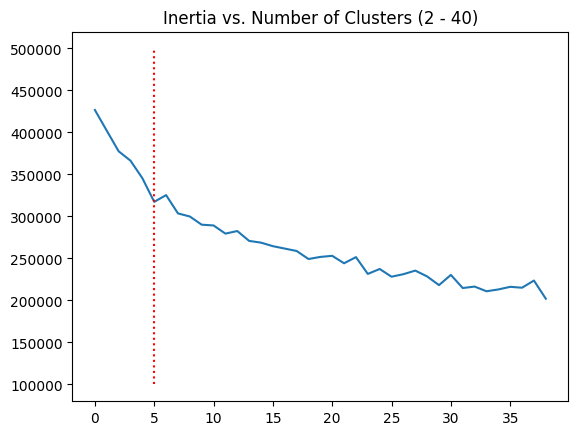

In [64]:
fig, ax = plt.subplots()
ax.set_title('Inertia vs. Number of Clusters (2 - 40)')
cluster_results.inertia.plot(ax=ax)
ax.vlines(x=clusters, ymin=100000, ymax=500000, colors='red', linestyles='dotted')
plt.show()

#### Plot Silohouette Score

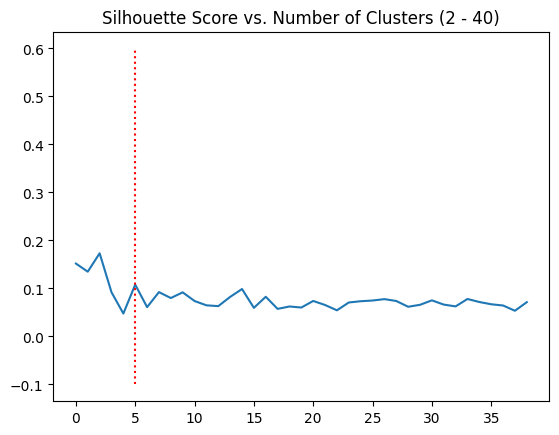

In [65]:
fig, ax = plt.subplots()
ax.set_title('Silhouette Score vs. Number of Clusters (2 - 40)')
cluster_results.silhouette.plot()
ax.vlines(x=clusters, ymin=-.1, ymax=.6, colors='red', linestyles='dotted')
plt.show()

Bu grafiklere bakarak optimum küme sayısını belirlemek için, yukarıdaki dirsek (elbow) grafiğine dayanarak küme sayısının yaklaşık olarak 5 olduğu sonucuna varabiliriz.

In [66]:
kmeans = MiniBatchKMeans(n_clusters = clusters, random_state = 42).fit(sd_pp)
kmeans
#bu kod sd_pp verisini clusters sayısına göre kümelere ayırır ve k-means modelini eğitir.

  File "c:\ProgramData\anaconda3\envs\python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\ProgramData\anaconda3\envs\python310\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\ProgramData\anaconda3\envs\python310\lib\subprocess.py", line 971, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\envs\python310\lib\subprocess.py", line 1456, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


MiniBatchKMeans(n_clusters=5, random_state=42)

In [67]:
# labels for each cluster
pred_labels = np.unique(kmeans.predict(sd_pp))
pred_labels

array([0, 1, 2, 3, 4], dtype=int32)

In [68]:
# Etiketleri almak için sd_pp üzerinde tahmin yapın.
sd_cluster_labels = pd.Series(kmeans.predict(sd_pp), index = sd_pp.index)
# her bir örnek için hangi kümeye ait olduğu (etiket) belirlenir
# Predicted küme etiketlerini bir listeye dönüştü
cluster_list = sd_cluster_labels.values.tolist()

In [69]:
# Cluster etiketini sd_modeling df veri çerçevesine ekle
sd_clustered = sd_modeling.copy()
sd_clustered.insert(1, 'cluster_label', cluster_list)

sd_clustered.head()
#labels_list küme etiketlerini sd_modeling veri çerçevesine cluster_label adlı yeni bir sütun olarak ekler

id  cluster_label  latitude  longitude neighbourhood_cleansed  \
0  33159143              1  32.91736 -117.07635          Scripps Ranch   
1  17138468              4  32.84067 -117.27443               La Jolla   
2  21898446              4  32.79797 -117.24250          Pacific Beach   
3  25948680              4  32.77545 -117.05923           College Area   
4   1756516              0  32.84619 -117.27558               La Jolla   

  zipcode property_type        room_type  accommodates  bathrooms  bedrooms  \
0   92131         House     Private room             1        1.0       1.0   
1   92037     Apartment  Entire home/apt             1        2.0       2.0   
2   92109     Townhouse     Private room             1        1.0       1.0   
3   92120     Apartment  Entire home/apt             1        1.0       1.0   
4   92037   Condominium     Private room             1        1.0       1.0   

   beds  bed_type  nightly_price  price_per_stay  security_deposit  \
0     1  Real Bed         1100.0          1100.0            1000.0   
1     3  Real Bed         1400.0          1400.0               0.0   
2     1  Real Bed         1250.0          1250.0               0.0   
3     1  Real Bed         1150.0          1150.0               0.0   
4     1  Real Bed          110.0           110.0             200.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0                1           0.0              60   
1           0.0                1           0.0              30   
2           0.0                1           0.0              30   
3           0.0                1           0.0              31   
4           0.0                1          50.0             180   

   maximum_nights  host_response_time  host_response_rate  host_is_superhost  \
0              90  within a few hours               100.0                  0   
1            1125         no response                 0.0                  0   
2              30         no response                 0.0                  0   
3              40         no response                 0.0                  0   
4             365        within a day                67.0                  0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                     1                       0   
1                        1.0                     1                       0   
2                        1.0                     1                       0   
3                        1.0                     1                       0   
4                        6.0                     1                       1   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                  0                0                  98.0   
1                  2                4                 100.0   
2                  0                0                  97.0   
3                  0                0                  98.0   
4                  2                4                  90.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   
2                    10.0                       10.0                   10.0   
3                    10.0                       10.0                   10.0   
4                     7.0                        7.0                    8.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   
2                         10.0                    10.0                 10.0   
3                         10.0                    10.0                 10.0   
4                          8.0                     9.0                 1

In [70]:
# save as csv
path = "data/"

sd_clustered.to_csv(path + 'sd_clustered')

In [71]:
#Cluster etiketini sd_modeling df veri çerçevesine ekle 
sd_pp_clustered = sd_pp.copy()
sd_pp_clustered.insert(0, 'cluster_label', cluster_list)

sd_pp_clustered.head()

cluster_label  Allied Gardens  Alta Vista  Amphitheater And Water Park  \
0              1             0.0         0.0                          0.0   
1              4             0.0         0.0                          0.0   
2              4             0.0         0.0                          0.0   
3              4             0.0         0.0                          0.0   
4              0             0.0         0.0                          0.0   

   Balboa Park  Bario Logan  Bay Ho  Bay Park  Bay Terrace  Bird Land  \
0          0.0          0.0     0.0       0.0          0.0        0.0   
1          0.0          0.0     0.0       0.0          0.0        0.0   
2          0.0          0.0     0.0       0.0          0.0        0.0   
3          0.0          0.0     0.0       0.0          0.0        0.0   
4          0.0          0.0     0.0       0.0          0.0        0.0   

   Bonita Long Canyon  Carmel Mountain  Carmel Valley  Chollas View  \
0                 0.0              0.0            0.0           0.0   
1                 0.0              0.0            0.0           0.0   
2                 0.0              0.0            0.0           0.0   
3                 0.0              0.0            0.0           0.0   
4                 0.0              0.0            0.0           0.0   

   City Heights East  City Heights West  Clairemont Mesa  College Area  \
0                0.0                0.0              0.0           0.0   
1                0.0                0.0              0.0           0.0   
2                0.0                0.0              0.0           0.0   
3                0.0                0.0              0.0           1.0   
4                0.0                0.0              0.0           0.0   

   Columbia  Core  Cortez Hill  Darnall  Del Cerro  Del Mar Heights  \
0       0.0   0.0          0.0      0.0        0.0              0.0   
1       0.0   0.0          0.0      0.0        0.0              0.0   
2       0.0   0.0          0.0      0.0        0.0              0.0   
3       0.0   0.0          0.0      0.0        0.0              0.0   
4       0.0   0.0          0.0      0.0        0.0              0.0   

   East Lake  East Village  Eastlake Trails  Eastlake Vistas  Eastlake Woods  \
0        0.0           0.0              0.0              0.0             0.0   
1        0.0           0.0              0.0              0.0             0.0   
2        0.0           0.0              0.0              0.0             0.0   
3        0.0           0.0              0.0              0.0             0.0   
4        0.0           0.0              0.0              0.0             0.0   

   Egger Highlands  El Cerritos  Emerald Hills  Encanto  Estlake Greens  \
0              0.0          0.0            0.0      0.0             0.0   
1              0.0          0.0            0.0      0.0             0.0   
2              0.0          0.0            0.0      0.0             0.0   
3              0.0          0.0            0.0      0.0             0.0   
4              0.0          0.0            0.0      0.0             0.0   

   Gaslamp Quarter  Gateway  Grant Hill  Grantville  Horton Plaza  \
0              0.0      0.0         0.0         0.0           0.0   
1              0.0      0.0         0.0         0.0           0.0   
2              0.0      0.0         0.0         0.0           0.0   
3              0.0      0.0         0.0         0.0           0.0   
4              0.0      0.0         0.0         0.0           0.0   

   Jomacha-Lomita  Kearny Mesa  Kensington  La Jolla  La Jolla Village  \
0             0.0          0.0         0.0       0.0               0.0   
1             0.0          0.0         0.0       1.0               0.0   
2             0.0          0.0         0.0       0.0               0.0   
3             0.0          0.0         0.0       0.0               0.0   
4             0.0          0.0         0.0       1.0               0.0   

   Lake Mu

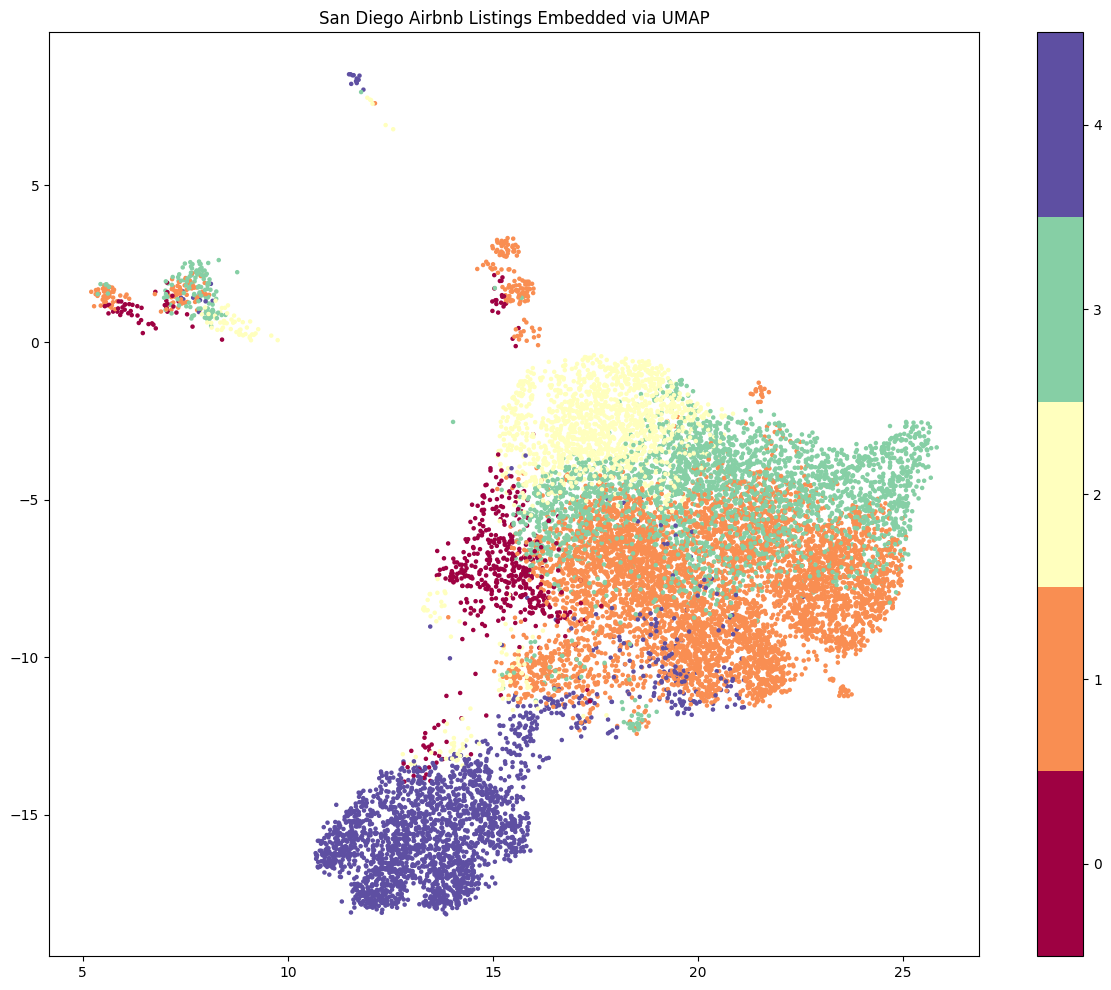

In [72]:
# plot 5 clusters with UMAP 
fig, ax = plt.subplots(figsize = (15,12))

plt.scatter(*embedding.T, s = 5, alpha = 1, c = kmeans.predict(sd_pp), cmap = 'Spectral')

labels = sorted(list(sd_cluster_labels.unique())) # cluster labels

cbar = plt.colorbar(boundaries=np.arange(6)-0.5) # 6 cluster labels
cbar.set_ticks(np.arange(5))
cbar.set_ticklabels(labels)
plt.title('San Diego Airbnb Listings Embedded via UMAP');

plt.show()

### Küme Etiketlerini Bokeh ile Anlamak

-5 küme/grup etiketi belirlemiş olsak da, her bir grubun birbirinden neyle ayrıldığını anlamak hala zor. Şimdi, her noktaya etiketler atayacak interaktif bir Bokeh dağılma grafiği oluşturacağım ve kümeler arasındaki benzerlikleri bulmaya çalışacağız.

In [73]:
from bokeh.resources import INLINE
from bokeh.plotting import figure, show
from bokeh.transform import factor_cmap

import bokeh.io

import umap.plot

bokeh.io.output_notebook(INLINE)

Loading BokehJS ...

In [74]:
embedding_map = umap.UMAP(n_neighbors=500, min_dist= .9, random_state=42).fit(sd_pp)

In [75]:
sd_pp_clustered.head(2)

cluster_label  Allied Gardens  Alta Vista  Amphitheater And Water Park  \
0              1             0.0         0.0                          0.0   
1              4             0.0         0.0                          0.0   

   Balboa Park  Bario Logan  Bay Ho  Bay Park  Bay Terrace  Bird Land  \
0          0.0          0.0     0.0       0.0          0.0        0.0   
1          0.0          0.0     0.0       0.0          0.0        0.0   

   Bonita Long Canyon  Carmel Mountain  Carmel Valley  Chollas View  \
0                 0.0              0.0            0.0           0.0   
1                 0.0              0.0            0.0           0.0   

   City Heights East  City Heights West  Clairemont Mesa  College Area  \
0                0.0                0.0              0.0           0.0   
1                0.0                0.0              0.0           0.0   

   Columbia  Core  Cortez Hill  Darnall  Del Cerro  Del Mar Heights  \
0       0.0   0.0          0.0      0.0        0.0              0.0   
1       0.0   0.0          0.0      0.0        0.0              0.0   

   East Lake  East Village  Eastlake Trails  Eastlake Vistas  Eastlake Woods  \
0        0.0           0.0              0.0              0.0             0.0   
1        0.0           0.0              0.0              0.0             0.0   

   Egger Highlands  El Cerritos  Emerald Hills  Encanto  Estlake Greens  \
0              0.0          0.0            0.0      0.0             0.0   
1              0.0          0.0            0.0      0.0             0.0   

   Gaslamp Quarter  Gateway  Grant Hill  Grantville  Horton Plaza  \
0              0.0      0.0         0.0         0.0           0.0   
1              0.0      0.0         0.0         0.0           0.0   

   Jomacha-Lomita  Kearny Mesa  Kensington  La Jolla  La Jolla Village  \
0             0.0          0.0         0.0       0.0               0.0   
1             0.0          0.0         0.0       1.0               0.0   

   Lake Murray  Lincoln Park  Linda Vista  Little Italy  Loma Portal  \
0          0.0           0.0          0.0           0.0          0.0   
1          0.0           0.0          0.0           0.0          0.0   

   Lynwood Hills  Marina  Memorial  Midtown  Midtown District  Mira Mesa  \
0            0.0     0.0       0.0      0.0               0.0        0.0   
1            0.0     0.0       0.0      0.0               0.0        0.0   

   Mission Bay  Mission Valley  Moreno Mission  Mount Hope  Mountain View  \
0          0.0             0.0             0.0         0.0            0.0   
1          0.0             0.0             0.0         0.0            0.0   

   Nestor  Normal Heights  North City  North Clairemont  North Hills  \
0     0.0             0.0         0.0               0.0          0.0   
1     0.0             0.0         0.0               0.0          0.0   

   Northwest  Oak Park  Ocean Beach  Old Town  Otay Ranch  Pacific Beach  \
0        0.0       0.0          0.0       0.0         0.0            0.0   
1        0.0       0.0          0.0       0.0         0.0            0.0   

   Palm City  Paradise Hills  Park West  Paseo Ranchoero  Rancho Bernadino  \
0        0.0             0.0        0.0              0.0               0.0   
1        0.0             0.0        0.0              0.0               0.0   

   Rancho Del Rey  Rancho Penasquitos  Rolando  Rolling Hills Ranch  \
0             0.0                 0.0      0.0                  0.0   
1             0.0                 0.0      0.0                  0.0   

   Roseville  Sabre Springs  San Carlos  San Ysidro  Scripps Ranch  \
0        0.0            0.0         0.0         0.0            1.0   
1        0.0            0.0         0.0         0.0            0.0   

   Serra Mesa  Sky Line  Sorrento Valley  South Park  Southcrest  Southwest  \
0         0.0       0.0              0.0         0.0         0.0        0.0   
1         0.0       0.0              0.0         0.0        

#### Reverse OHE

- Aşağıdaki etkileşimli Bokeh grafiğini daha anlaşılır hale getirebilmek için, her bir noktaya etiket atamak amacıyla  `sd_pp_clustered` veri çerçevesindeki kodlamayı tersine çevirmem gerekecek


Bu nedenle, sd_pp_clustered veri çerçevesini, aşağıda gösterildiği gibi, sd_trans'teki orijinal sütun formatına benzer şekilde biçimlendirmem gerekecek.

In [76]:
sd_trans.head(2)

neighbourhood_cleansed zipcode property_type        room_type  bed_type  \
0          Scripps Ranch   92131         House     Private room  Real Bed   
1               La Jolla   92037     Apartment  Entire home/apt  Real Bed   

   host_response_time          cancellation_policy  accommodates  bathrooms  \
0  within a few hours  strict_14_with_grace_period             1        1.0   
1         no response  strict_14_with_grace_period             1        2.0   

   bedrooms  beds  nightly_price  price_per_stay  security_deposit  \
0       1.0     1         1100.0          1100.0            1000.0   
1       2.0     3         1400.0          1400.0               0.0   

   cleaning_fee  guests_included  extra_people  minimum_nights  \
0           0.0                1           0.0              60   
1           0.0                1           0.0              30   

   maximum_nights  host_response_rate  host_is_superhost  \
0              90               100.0                  0   
1            1125                 0.0                  0   

   host_total_listings_count  host_has_profile_pic  host_identity_verified  \
0                        1.0                     1                       0   
1                        1.0                     1                       0   

   number_of_reviews  number_of_stays  review_scores_rating  \
0                  0                0                  98.0   
1                  2                4                 100.0   

   review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  \
0                    10.0                       10.0                   10.0   
1                    10.0                       10.0                   10.0   

   review_scores_communication  review_scores_location  review_scores_value  \
0                         10.0                    10.0                 10.0   
1                         10.0                    10.0                 10.0   

   requires_license  instant_bookable  is_business_travel_ready  \
0                 0                 1                         0   
1                 0                 1                         0   

   require_guest_profile_picture  require_guest_phone_verification  
0                              0                                 0  
1                              0                                 0

In [77]:
# Küme etiketlerini tanımnla.
cluster_df = pd.DataFrame(sd_pp_clustered['cluster_label']) 

# assigns neighborhood
neighborhood_df = pd.DataFrame(sd_pp_clustered.loc[:,'Allied Gardens':'Yosemite Dr'].idxmax(axis = 1)).rename(columns = {0:'Neighborhood'})

# assigns property type
property_df = pd.DataFrame(sd_pp_clustered.loc[:,'Aparthotel':'Villa'].idxmax(axis = 1)).rename(columns = {0:'Property'})

# assigns room type
room_df = pd.DataFrame(sd_pp_clustered.loc[:,'Entire home/apt':'Shared room'].idxmax(axis = 1)).rename(columns = {0:'Room Type'})

# assigns price
price = pd.DataFrame('$' + sd_trans['price_per_stay'].astype(str))

# assigns rating
rating = pd.DataFrame(sd_trans['review_scores_rating'].astype(int))


# concat all the dfs
cluster_hover_data = pd.concat([cluster_df, price, rating, neighborhood_df, property_df, room_df], axis = 1)

cluster_hover_data


cluster_label price_per_stay  review_scores_rating   Neighborhood  \
0                  1        $1100.0                    98  Scripps Ranch   
1                  4        $1400.0                   100       La Jolla   
2                  4        $1250.0                    97  Pacific Beach   
3                  4        $1150.0                    98   College Area   
4                  0         $110.0                    90       La Jolla   
...              ...            ...                   ...            ...   
13035              2        $3000.0                    96    Mission Bay   
13036              2        $2823.0                    83       La Jolla   
13037              2         $208.0                    92    Mission Bay   
13038              2        $1305.0                    80       La Jolla   
13039              2         $398.0                    80        Midtown   

          Property        Room Type  
0            House     Private room  
1        Apartment  Entire home/apt  
2        Townhouse     Private room  
3        Apartment  Entire home/apt  
4      Condominium     Private room  
...            ...              ...  
13035        Villa  Entire home/apt  
13036        House  Entire home/apt  
13037        House  Entire home/apt  
13038        House  Entire home/apt  
13039  Condominium  Entire home/apt  

[13040 rows x 6 columns]

In [78]:
embedding_map

UMAP(min_dist=0.9, n_jobs=1, n_neighbors=500, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [79]:
kmeans.predict(sd_pp)

array([1, 4, 4, ..., 2, 2, 2], dtype=int32)

### Her bir Airbnb listesi için etiketler ile etkileşimli Bokeh serbest grafik çiz

In [80]:
p = umap.plot.interactive(embedding_map, 
                          labels = kmeans.predict(sd_pp), # Kümeleri renk kodlarıyla ayırır
                          point_size=5, alpha = 0.3,
                          hover_data=cluster_hover_data, # Küme etiketlerini al
                          width = 800, height = 800)
umap.plot.show(p)

### Küme Gruplarını Görselleştirme

In [81]:
# Plot için sütunları temizlemek
cluster_hover_data['price_per_stay'] = cluster_hover_data['price_per_stay'].str.replace('$', '')
cluster_hover_data['price_per_stay'] = cluster_hover_data['price_per_stay'].astype(float)
cluster_hover_data['cluster_label'] = cluster_hover_data['cluster_label'].astype('category')
cluster_hover_data

cluster_label  price_per_stay  review_scores_rating   Neighborhood  \
0                 1          1100.0                    98  Scripps Ranch   
1                 4          1400.0                   100       La Jolla   
2                 4          1250.0                    97  Pacific Beach   
3                 4          1150.0                    98   College Area   
4                 0           110.0                    90       La Jolla   
...             ...             ...                   ...            ...   
13035             2          3000.0                    96    Mission Bay   
13036             2          2823.0                    83       La Jolla   
13037             2           208.0                    92    Mission Bay   
13038             2          1305.0                    80       La Jolla   
13039             2           398.0                    80        Midtown   

          Property        Room Type  
0            House     Private room  
1        Apartment  Entire home/apt  
2        Townhouse     Private room  
3        Apartment  Entire home/apt  
4      Condominium     Private room  
...            ...              ...  
13035        Villa  Entire home/apt  
13036        House  Entire home/apt  
13037        House  Entire home/apt  
13038        House  Entire home/apt  
13039  Condominium  Entire home/apt  

[13040 rows x 6 columns]

In [82]:
# save as csv
path = "data/"

cluster_hover_data.to_csv(path + 'cluster_hover_data')

#### Kümelerin Dağılımı
 take a look at the distribution of each cluster group. 

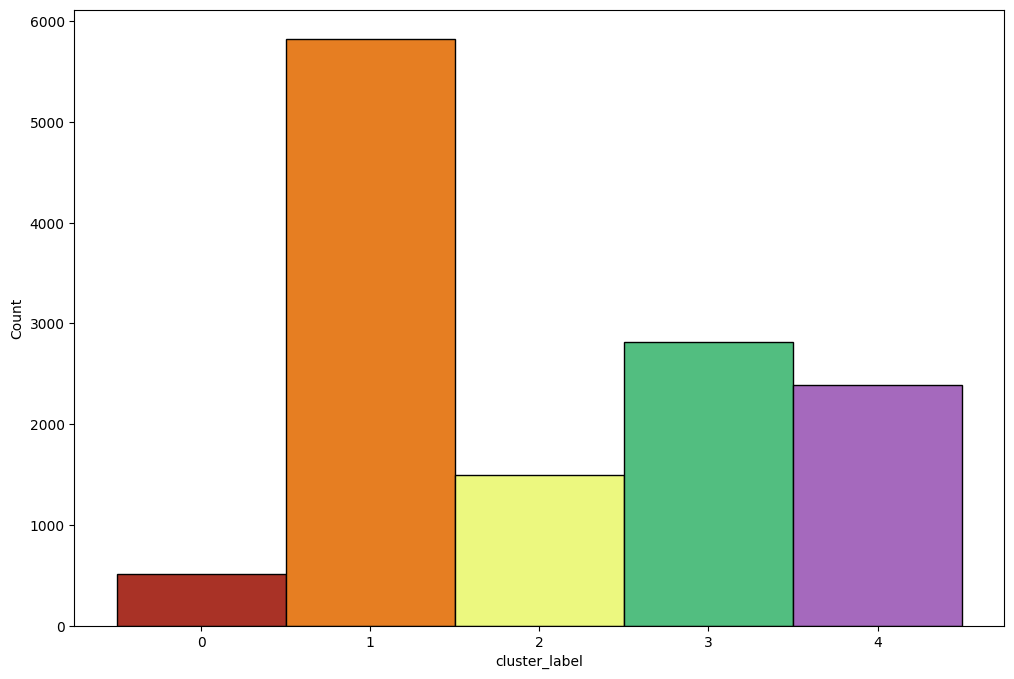

In [83]:
fig, axes = plt.subplots(figsize=(12,8))

ax = sns.histplot(cluster_hover_data['cluster_label'])

# set bar colors
ax.patches[0].set_facecolor('#A93226')
ax.patches[1].set_facecolor('#E67E22')
ax.patches[2].set_facecolor('#ECF87F')
ax.patches[3].set_facecolor('#52BE80')
ax.patches[4].set_facecolor('#A569BD')

plt.show()

In [84]:
# assigning colors to each label
palette = {0: '#A93226', 1:'#E67E22', 2:'#ECF87F', 3:'#52BE80', 4:'#A569BD'}

#### Room Type

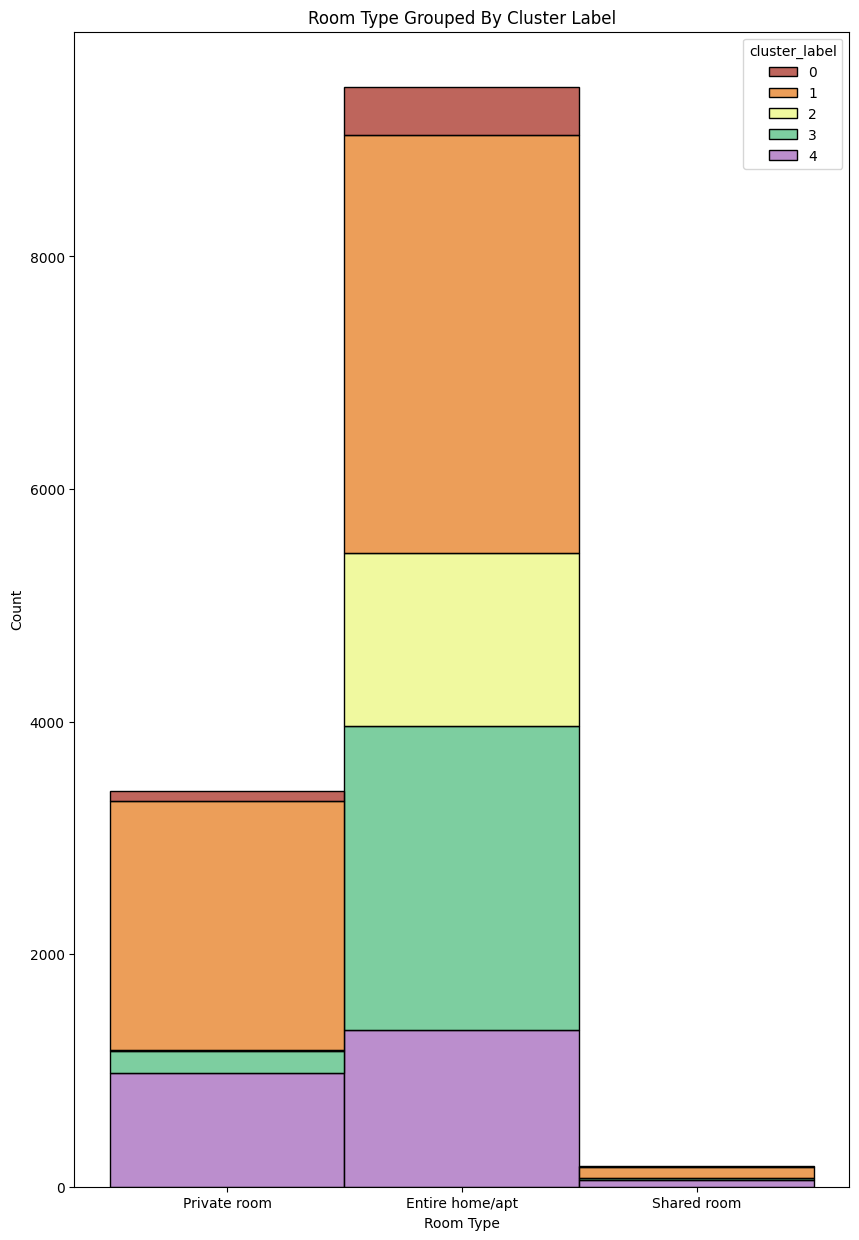

In [85]:
fig, axes = plt.subplots(figsize=(10,15))

ax = sns.histplot(data=cluster_hover_data, 
             x='Room Type', 
             hue='cluster_label', palette = palette,
             multiple="stack").set(title='Room Type Grouped By Cluster Label')

plt.show()

#### Review Score Ratings

**Ratings Above 70**

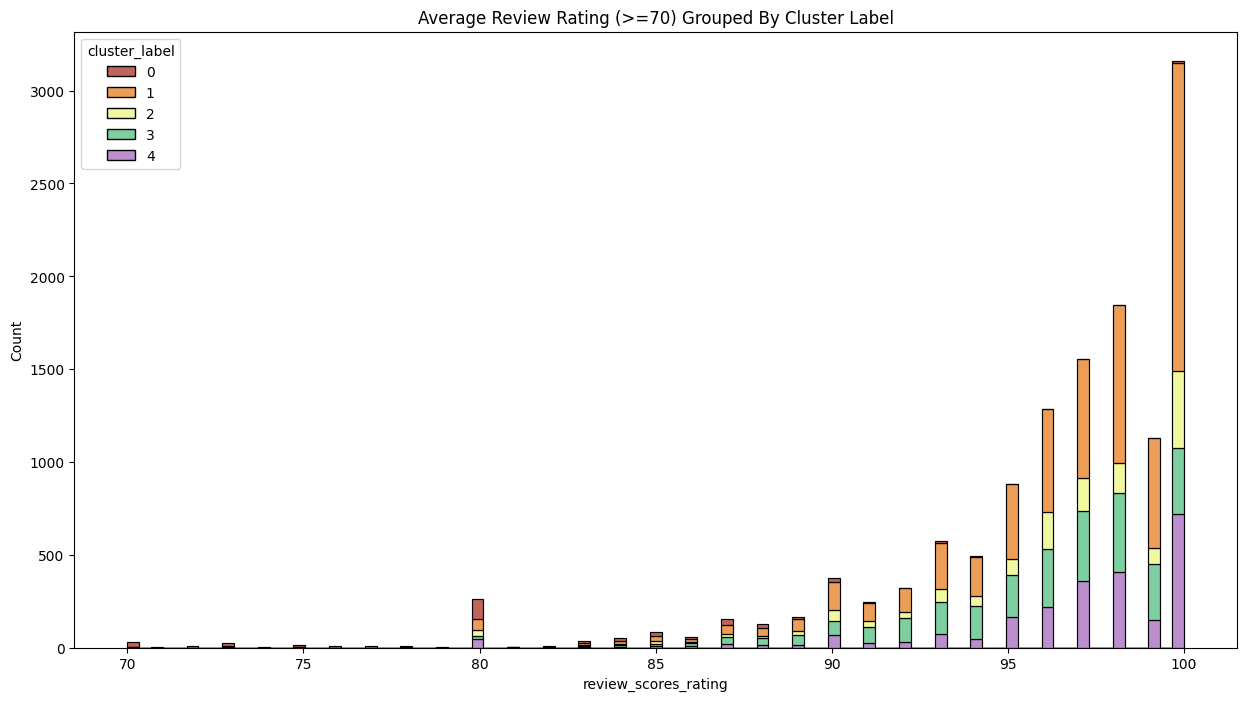

In [86]:
fig, axes = plt.subplots(figsize=(15,8))

#70'ten büyük puanlara sahip bir filtre oluşturun ve aykırı değerleri çıkarın
greater_than_70 = cluster_hover_data[cluster_hover_data['review_scores_rating'] >= 70]

ax = sns.histplot(data=greater_than_70, 
             x='review_scores_rating', 
             hue='cluster_label', palette = palette,
             multiple="stack").set(title='Average Review Rating (>=70) Grouped By Cluster Label')

plt.show()

**Ratings Below 70**

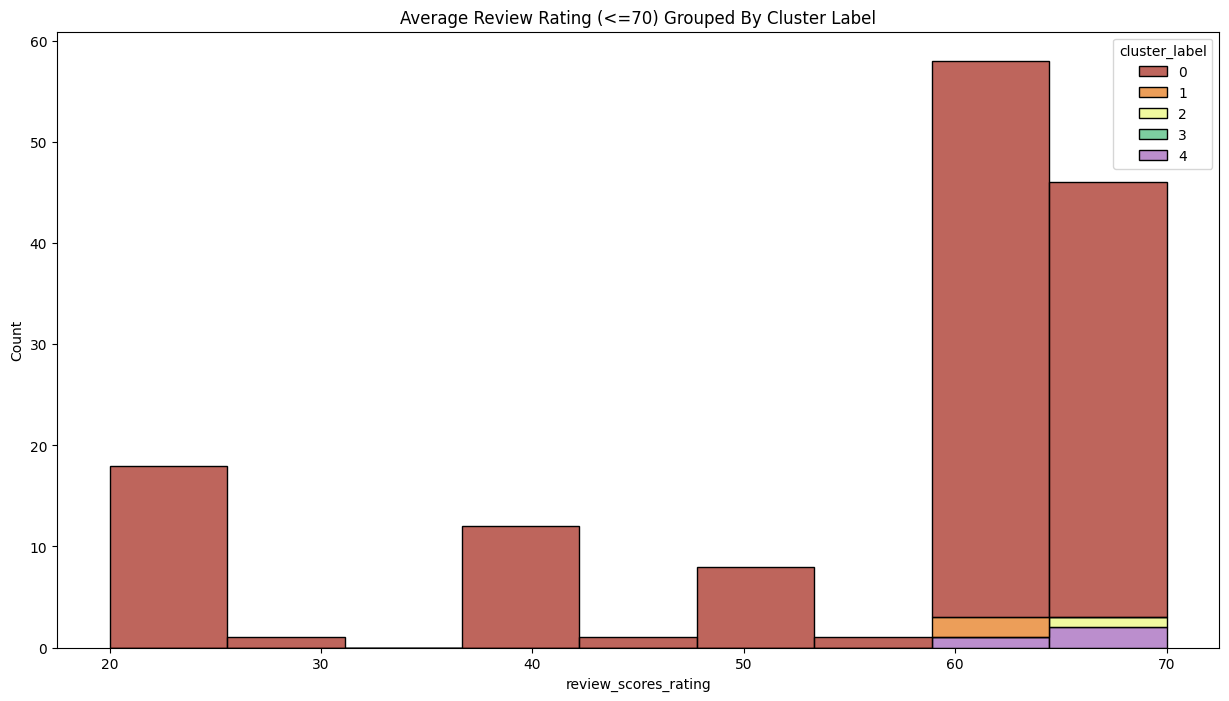

In [87]:
fig, axes = plt.subplots(figsize=(15,8))

# Aykırı değerleri çıkarmak için 70'ten düşük puanlara sahip bir filtre oluştur
less_than_70 = cluster_hover_data[cluster_hover_data['review_scores_rating'] <= 70]

sns.histplot(data=less_than_70, 
             x='review_scores_rating', 
             hue='cluster_label', palette = palette, 
             multiple="stack").set(title='Average Review Rating (<=70) Grouped By Cluster Label')

plt.show()

#### Price Per Stay

Şimdi her küme etiketinin konaklama başına ortalama fiyatını çizelim. Çok fazla aykırı değer olduğundan, sonuçları 1.000 $'dan daha düşük olan ilanlarla sınırlayacağız.

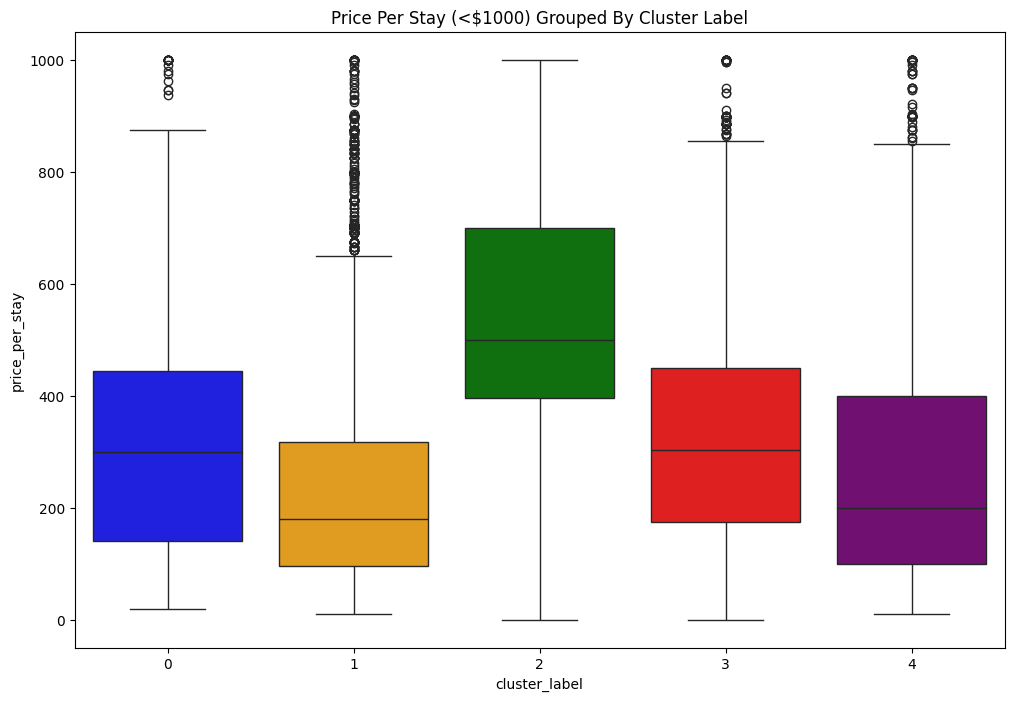

In [88]:
fig, axes = plt.subplots(figsize=(12,8))

# Konaklama başına fiyat için 1.000 $'dan daha düşük bir filtre oluşturun, böylece aykırı değerleri kaldırmış olucaz
less_than_2000 = cluster_hover_data[cluster_hover_data['price_per_stay'] <= 1000]

sns.boxplot(x = less_than_2000['cluster_label'], 
            y = less_than_2000['price_per_stay'],
            palette = {
    '0': 'blue',
    '1': 'orange',
    '2': 'green',
    '3': 'red',
    '4': 'purple'
}).set(title='Price Per Stay (<$1000) Grouped By Cluster Label')

plt.show()

#### Property Types

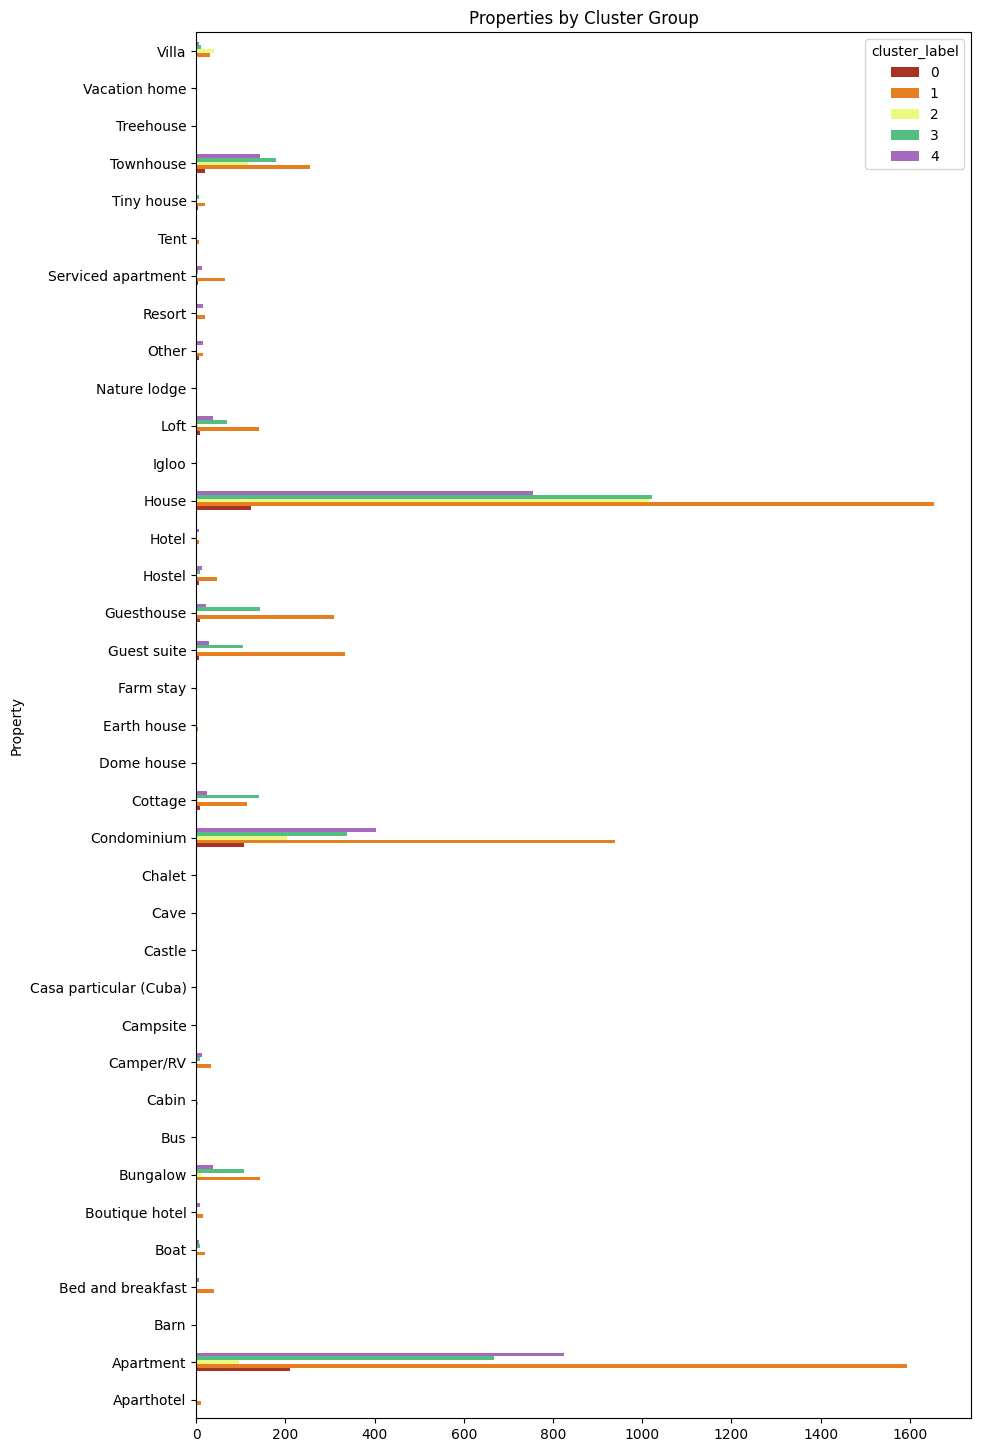

In [89]:
cluster_hover_data.groupby(['Property', 'cluster_label']).size().unstack(fill_value=0).plot.barh(figsize=(10,18), 
                                                                                                 color = palette)

plt.title('Properties by Cluster Group')
plt.show()

### Conclusions About the Clusters

**Cluster Label 0 (Red) - Favorable high end listings**
- Favorable and wide range of review rating. Most expensive listings and mostly consist of entire home room types.
  
**Cluster Label 1 (Orange) - Favorable highly rated & moderately priced listings**
- Popular group, generally > 90 review ratings, relatively inexpensive. Mostly houses or private rooms, wide range of property types.
  
**Cluster Label 2 (Yellow) - Favorable moderately priced diverse listings**
- Most popular group, mostly favorable ratings. Relatively low priced. Wide range of property types.
  
**Cluster Label 3 (Green) - Favorable and least expensive listings**
- Popular group and wide range of review rating. Least expensive group. Wide range of property types.
  
**Cluster Label 4 (Purple) - Unfavorable listings**
- Least popular group and lowest rated listings.


### Küme Etiketleri Hakkında Sonuçlar

**Küme Etiketi 0 (Kırmızı) - Uygun fiyatlı yüksek kaliteli ilanlar**
Olumlu ve geniş bir inceleme puanı aralığına sahip. En pahalı ilanlar ve çoğunlukla tüm ev tipi odalardan oluşur.

**Küme Etiketi 1 (Turuncu) - Uygun fiyatlı yüksek puanlı ve orta fiyatlı ilanlar**
Popüler grup, genellikle > 90 inceleme puanı, nispeten uygun fiyatlı. Çoğunlukla evler veya özel odalar, geniş bir mülk tipi yelpazesi.

**Küme Etiketi 2 (Sarı) - Uygun fiyatlı orta fiyatlı çeşitli ilanlar**
En popüler grup, çoğunlukla olumlu puanlar. Nispeten düşük fiyatlı. Geniş bir mülk tipi yelpazesi.

**Küme Etiketi 3 (Yeşil) - Uygun fiyatlı ve en ucuz ilanlar**
Popüler grup ve geniş bir inceleme puanı aralığına sahip. En ucuz grup. Geniş bir mülk tipi yelpazesi.

**Küme Etiketi 4 (Mor) - Olumsuz ilanlar**
En az popüler grup ve en düşük puanlı ilanlar.